<a href="https://colab.research.google.com/github/SarkarPriyanshu/DataScienceAssign/blob/main/Internship_Task_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of Contents

1. [Problem Statement](#problem-statement)
2. [Data Loading and Optimizations](#data-loading-and-optimizations)
3. [Basic Analysis](#basic-analysis)
   
   3.1. [Basic Analysis Observations](#basic-analysis-observations)

4. [Remove Observations Containing Both Target and Feature Value](#remove-observations-containing-both-target-and-feature-value)
5. [Handling Imbalanced Dataset](#handling-imbalanced-dataset)
   
   5.1. [Under Sampling (Random Undersampling)](#under-sampling-random-undersampling)

   5.1.1. [Random UnderSampling for Imbalanced Data Observations](#random-undersampling-for-imbalanced-data-observations)
6. [Feature Engineering (Increase Relation Between Target and Features)](#feature-engineering-increase-relation-between-target-and-features)

   6.1. [Experimentation with Polynomial Features](#experimentation-with-polynomial-features)

     6.1.1. [Experimentation with Polynomial Features Observations](#experimentation-with-polynomial-features-observations)
    
     6.1.2. [Experimentation with Feature Transformation](#experimentation-with-feature-transformation)
    
      6.1.2.1 [Experimentation with Feature Transformation Observations](#experimentation-with-feature-transformation-observations)
7. [Handling Multicollinearity and Statistical Testing](#handling-multicollinearity-and-statistical-testing)

8. [Putting All Together Using Pipeline and Functions](#putting-all-together-using-pipeline-and-functions)

   8.1. [Putting All Together Using Pipeline and Functions Observations](#putting-all-together-using-pipeline-and-functions-observations)

     8.1.1. [Model Performance Comparison](#model-performance-comparison)

9. [Fine Tuning Models Performance](#fine-tuning-models-performance)




In [1]:
!pip install feature-engine --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 4.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 1. Problem Statement
  -  case requires trainees to develop a model for predicting fraudulent transactions for a
financial company and use insights from the model to develop an actionable plan


 ***Data Description***

- **Step:** Maps a unit of time in the real world. In this case, 1 step is equivalent to 1 hour of time. The total number of steps is 744, representing a 30-day simulation.

- **Type:** Describes the type of transaction. Possible values include CASH-IN, CASH-OUT, DEBIT, PAYMENT, and TRANSFER.

- **Amount:** Represents the amount of the transaction in the local currency.

- **NameOrig:** The customer who initiated the transaction.

- **OldbalanceOrg:** Initial balance of the originator's account before the transaction.

- **NewbalanceOrig:** New balance of the originator's account after the transaction.

- **NameDest:** The customer who is the recipient of the transaction.

- **OldbalanceDest:** Initial balance of the recipient's account before the transaction. Note that there is no information for customers that start with M (Merchants).

- **NewbalanceDest:** New balance of the recipient's account after the transaction. Note that there is no information for customers that start with M (Merchants).

- **isFraud:** Indicates transactions made by fraudulent agents within the simulation. The fraudulent behavior aims to profit by taking control of customer accounts and attempting to empty funds through transfers to another account and subsequent cashing out.

- **isFlaggedFraud:** The business model aims to control massive transfers from one account to another and flags illegal attempts. In this dataset, an illegal attempt is defined as an attempt to transfer more than 200,000 in a single transaction.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import mutual_info_classif
from  sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.metrics import confusion_matrix,classification_report,precision_score,recall_score,f1_score


from imblearn.under_sampling import RandomUnderSampler
from feature_engine.encoding import CountFrequencyEncoder
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.selection import SmartCorrelatedSelection

from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV



import warnings
warnings.filterwarnings("ignore")

# 2. Data Loading and Optimizations

In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/DATA/Fraud.csv') \
      .astype({'type':'category', # Doing this type conversion we can reduce dataset size upto 28% from its original size
               'isFraud':'int8',
               'isFlaggedFraud':'int8',
               'step':'int32'})

# 3. Basic Analysis

In [ ]:
df.shape

(6362620, 11)

In [ ]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df.tail(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


In [ ]:
df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            int32   
 1   type            category
 2   amount          float64 
 3   nameOrig        object  
 4   oldbalanceOrg   float64 
 5   newbalanceOrig  float64 
 6   nameDest        object  
 7   oldbalanceDest  float64 
 8   newbalanceDest  float64 
 9   isFraud         int8    
 10  isFlaggedFraud  int8    
dtypes: category(1), float64(5), int32(1), int8(2), object(2)
memory usage: 382.3+ MB


In [ ]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08
isFraud,6362620.0,1.290820e-03,3.590480e-02,0.0,0.00,0.000,0.000000e+00,1.000000e+00
isFlaggedFraud,6362620.0,2.514687e-06,1.585775e-03,0.0,0.00,0.000,0.000000e+00,1.000000e+00


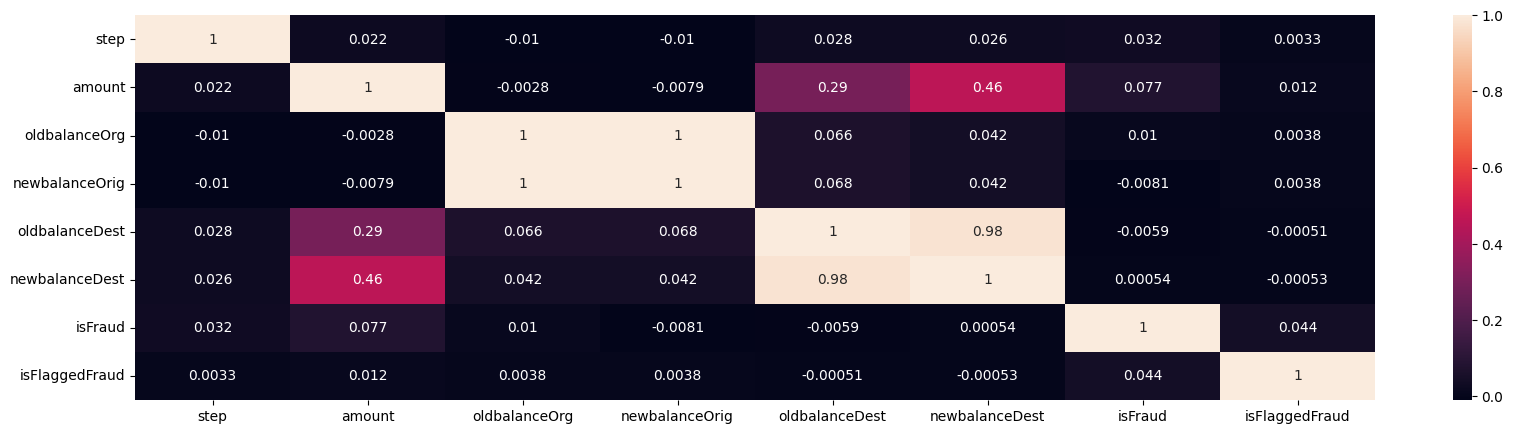

In [ ]:
plt.figure(figsize=(20,5))
sns.heatmap(df.corr(),annot=True)
plt.show()

Text(0, 0.5, 'Counts')

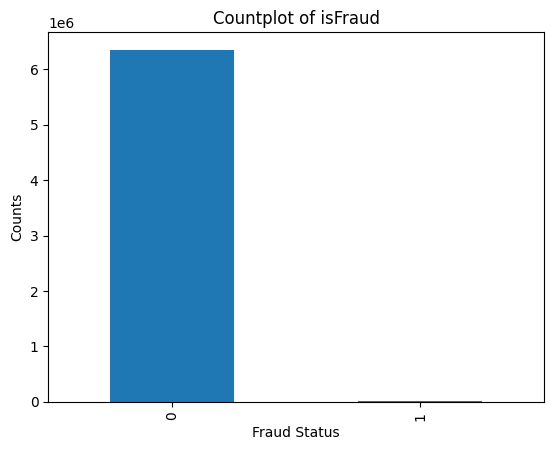

In [ ]:
df['isFraud'].value_counts().plot(kind='bar')
plt.title('Countplot of isFraud')
plt.xlabel('Fraud Status')
plt.ylabel('Counts')

In [ ]:
df['nameOrig'].nunique(),df['nameDest'].nunique()

(6353307, 2722362)

In [ ]:
df.query('isFraud == 1')['nameOrig'].nunique(),df.query('isFraud == 1')['nameDest'].nunique()

(8213, 8169)

## 3.1. Basic Analysis Observations

  - **Remove observations those contain on both target and feature value** : there are a huge number of observation that contain 0.0 value, features like 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'. We can remove the observation that are unnecessary.

  - **Remove unnecessary Features** : nameOrig and nameDest are features with very high caridiality which is not practicle to use for predictions

  - **Handle Imbalance Data** : As our target is to detect fraud transactions it is sure we are going to face imbalance issue, we can deal with imbalance data using oversampling or undersampling techniques.

  - **Increase Relation Between Taget and Features** :  Although we are dealing with binary classification there should be atleast a correlation expectation with target columns to use linear-models, to deal with this we can use feature upscaling techniques where we move the feature to higher dimensions.

  - **Handling Outliers** : Some feature are very skewed in nature that lead to extreme outliers toward tail that affect model in training as well as predictions.

  - **Statistical Test** : Do statistical test to find the top features help to predict the target columns, example (Mutual Information,Chi Square)

   

# 4. Remove observations those contain on both target and feature value

 - Plan of action
    - Find the observation that contain 0.0 in feature column as well as on target column
    - We know that the target column is imbalanced so we rather need to somehow reduce the no of observations from majority class i.e isFraud == 0

In [ ]:
# Identify indexes of rows with zero balances and non-fraudulent transactions for each relevant column
oldbalanceOrgZeroIndexes = set(df.query('oldbalanceOrg == 0.0 & isFraud == 0').index)
newbalanceOrigZeroIndexes = set(df.query('newbalanceOrig == 0.0 & isFraud == 0').index)
oldbalanceDestZeroIndexes = set(df.query('oldbalanceDest == 0.0 & isFraud == 0').index)
newbalanceDestZeroIndexes = set(df.query('newbalanceDest == 0.0 & isFraud == 0').index)

# Find the common indexes where all specified conditions are met
ZeroIndexes = oldbalanceOrgZeroIndexes.intersection(newbalanceOrigZeroIndexes,
                                                    oldbalanceDestZeroIndexes,
                                                    newbalanceDestZeroIndexes)


In [ ]:
df.iloc[list(ZeroIndexes)].shape

(774269, 11)

In [ ]:
NonZeroDf = df.drop(list(ZeroIndexes),axis=0)

12.16 % of total observations are useless

# 5. Handling Imabalance Dataset
  
  ***Plan of actions***
  - Experiment with different sampling techniques
  - fit sample models like logistic regressor, svm or knn with no parameter tunings to check the performace of resampling techniques
  - Based on highest performance will be choosen and moved to next step

  
  ***Why we are doing this?***
    - to reduce the observations and balance the target columns
    

### 5.1.1. Under Sampling (Random Undersampling)
- Under Sampling Methods are the methods to reduce the number of sample from majority class in our case we have 6354407 transactions belongs to clean transaction where 8213 of fraud transactions (0.129 % of minority class compaired to majority class).

- We are using undersampling techniques because the majority class are those observation who have not shown the sign of fraud transactions and our main goal is to takle the fraud transaction, in undersampling techniques we remove unnecessary observations from majorite class to balance the target columns

    - RandomUnderSampler is a technique used in the field of machine learning to address class imbalance in a dataset, particularly in binary classification problems. Class imbalance occurs when one class (typically the minority class) has significantly fewer instances than the other class (majority class). This imbalance can lead machine learning models to be biased towards the majority class, resulting in poor performance on the minority class.

In [ ]:
X,y = NonZeroDf.drop('isFraud',axis=1),NonZeroDf['isFraud']

cf = CountFrequencyEncoder(variables=['type'],encoding_method='frequency')
cf.fit(X, y)

X_tranformed = cf.transform(X)

X_tranformed.drop(['nameOrig',	'nameDest'],axis=1,inplace=True)

In [ ]:
def ShowBalancedDataPerformance(sampling_model=None, model=None, X=None, y=None,no_sampling_model=True):
    """
    Evaluate the performance of a machine learning model on a balanced dataset.

    Parameters:
    - sampling_model: An oversampling or undersampling model to handle imbalanced datasets.
    - model: The machine learning model for performance evaluations.
    - X: Feature matrix.
    - y: Target variable.

    Returns:
    None
    """
    X_resampled, y_resampled = None, None

    if no_sampling_model:
      print('***********With Balanced Data set***************')
      print()
      # Resample the imbalanced dataset using the provided sampling model
      X_resampled, y_resampled = sampling_model.fit_resample(X, y)
      print(f'X Shape : {X_resampled.shape},Y Shape : {y_resampled.shape}\n')

    else:
      print('***********Without Balanced Data set************')
      print()
      X_resampled, y_resampled = X,y
      print(f'X Shape : {X_resampled.shape},Y Shape : {y_resampled.shape}\n')



    # Create and train the machine learning model on the resampled data
    X_train, X_other, y_train, y_other = train_test_split(X_resampled,y_resampled,test_size=0.3,random_state=101,stratify=y_resampled)
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,test_size=0.3,random_state=101,stratify=y_other)

    model_instance = model()
    model_instance.fit(X_train, y_train)

    # Make predictions on the validation set
    val_pred = model_instance.predict(X_val)

    print('************Confusion Matrix****************')
    print()
    display(pd.DataFrame(confusion_matrix(y_val, val_pred), index=['0', '1'], columns=['0', '1']))

    # Display classification report
    print('*************classification report************')
    print()
    print(classification_report(y_val, val_pred))
    print()

    # Display precision and recall scores
    print(f'************Validation Performance Metrics***********\n\nPrecision: {precision_score(y_val, val_pred)}\nRecall: {recall_score(y_val, val_pred)}\nf1score: {f1_score(y_val, val_pred)}\n')


In [ ]:
rus = RandomUnderSampler(
    sampling_strategy='auto',
    random_state=0,
    replacement=False
)

ShowBalancedDataPerformance(rus,LogisticRegression,X,y)
print()
ShowBalancedDataPerformance(None,LogisticRegression,X,y,False)

***********With Balanced Data set***************

X Shape : (16426, 11),Y Shape : (16426,)

************Confusion Matrix****************



,0,1
0,1544,181
1,170,1554


*************classification report************

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1725
           1       0.90      0.90      0.90      1724

    accuracy                           0.90      3449
   macro avg       0.90      0.90      0.90      3449
weighted avg       0.90      0.90      0.90      3449


************Validation Performance Metrics***********

Precision: 0.8956772334293948
Recall: 0.9013921113689095
f1score: 0.8985255854293149


***********Without Balanced Data set************

X Shape : (5588351, 11),Y Shape : (5588351,)

************Confusion Matrix****************



,0,1
0,1170465,1364
1,951,774


*************classification report************

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1171829
           1       0.36      0.45      0.40      1725

    accuracy                           1.00   1173554
   macro avg       0.68      0.72      0.70   1173554
weighted avg       1.00      1.00      1.00   1173554


************Validation Performance Metrics***********

Precision: 0.36202057998129095
Recall: 0.44869565217391305
f1score: 0.40072482526533787



In [ ]:
ShowBalancedDataPerformance(rus,SVC,X,y)
# ShowBalancedDataPerformance(None,SVC,X,y,False)

***********With Balanced Data set***************

X Shape : (16426, 11),Y Shape : (16426,)

************Confusion Matrix****************



,0,1
0,1704,21
1,516,1208


*************classification report************

              precision    recall  f1-score   support

           0       0.77      0.99      0.86      1725
           1       0.98      0.70      0.82      1724

    accuracy                           0.84      3449
   macro avg       0.88      0.84      0.84      3449
weighted avg       0.88      0.84      0.84      3449


************Validation Performance Metrics***********

Precision: 0.9829129373474369
Recall: 0.7006960556844548
f1score: 0.8181510328479512



In [ ]:
ShowBalancedDataPerformance(rus,KNeighborsClassifier,X,y)
ShowBalancedDataPerformance(None,KNeighborsClassifier,X,y,False)

***********With Balanced Data set***************

X Shape : (16426, 11),Y Shape : (16426,)

************Confusion Matrix****************



,0,1
0,1615,110
1,65,1659


*************classification report************

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1725
           1       0.94      0.96      0.95      1724

    accuracy                           0.95      3449
   macro avg       0.95      0.95      0.95      3449
weighted avg       0.95      0.95      0.95      3449


************Validation Performance Metrics***********

Precision: 0.9378179762577727
Recall: 0.9622969837587007
f1score: 0.9498997995991985

***********Without Balanced Data set************

X Shape : (5588351, 11),Y Shape : (5588351,)

************Confusion Matrix****************



,0,1
0,1171656,173
1,555,1170


*************classification report************

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1171829
           1       0.87      0.68      0.76      1725

    accuracy                           1.00   1173554
   macro avg       0.94      0.84      0.88   1173554
weighted avg       1.00      1.00      1.00   1173554


************Validation Performance Metrics***********

Precision: 0.8711839166046166
Recall: 0.6782608695652174
f1score: 0.7627118644067796



#### 5.1.1 Random UnderSampling for Imbalanced Data Observations

Here we applied the Random UnderSampling technique to address imbalanced data.

***Advantages***
- Very intuitive
- Less complex, leading to shorter training time
- High accuracy

***Disadvantages***
- Removes observations (in this case, we only use 0.25% of the total observations)
- Data loss

***Performance Comparison with and without Sampling Technique***

***Logistic Regressor***

| Metric                        | With Sampling Technique   | Without Sampling         |
| ----------------------------- | ------------------------- | ------------------------ |
| Precision                     | 0.923                     | 0.352                    |
| Recall                        | 0.899                     | 0.434                    |
| F1 Score                      | 0.911                     | 0.389                    |


***Support Vector Classifier***

| Metric                        | With Sampling Technique   | Without Sampling         |
| ----------------------------- | ------------------------- | ------------------------ |
| Precision                     | 0.9859                   |  Not able to process                   |
| Recall                        | 0.6914                    | Not able to process                   |
| F1 Score                      | 0.812                    | Not able to process  

***KNeighbors Classifier***

| Metric                        | With Sampling Technique   | Without Sampling         |
| ----------------------------- | ------------------------- | ------------------------ |
| Precision                     | 0.95008                |  0.8795                  |
| Recall                        | 0.9605                    | 0.6771                   |
| F1 Score                      | 0.9552                   | 0.7651  



<br/>

***We can clearly see that there are performance improvement after balancing the target columns although we are lossing a very huge amount of observations.***

In [ ]:
X_resampled, y_resampled = rus.fit_resample(X_tranformed, y)

In [ ]:
print(f'Independent features dimensions after handling imbalance : {X_resampled.shape},\nTarget features dimensions after handling imbalance : {y_resampled.shape}')

Independent features dimensions after handling imbalance : (16426, 8),
Target features dimensions after handling imbalance : (16426,)


In [ ]:
X_train, X_other, y_train, y_other = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=101, stratify=y_resampled)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.3, random_state=101, stratify=y_other)

# 6. Feature Engineering (Increase Relation Between Taget and Features)

## 6.1. Experimentation with Polynmial Features

In [ ]:
def FindBestDegreeOfPolynomial(model=None, X_train=None, y_train=None, X_val=None, y_val=None):
    """
    Find the best degree of polynomial features for a given model by evaluating precision, recall, and F1 scores.

    Parameters:
    - model: The machine learning model for testing.
    - X: Feature matrix.
    - y: Target variable.

    Returns:
    - Dictionary containing precision, recall, and F1 scores for training and validation sets across different polynomial degrees.
    """

    # Lists to store scores for analysis
    Precision_train = list()
    Precision_val = list()
    Recall_train = list()
    Recall_val = list()
    F1_train = list()
    F1_val = list()

    # Loop through different polynomial degrees
    for degree in range(1, 6):
        # Create polynomial features
        pf = PolynomialFeatures(degree=degree, include_bias=False, interaction_only=True)
        X_transformed = pf.fit_transform(X_train)

        # Train the model
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        val_pred = model.predict(X_val)

        # Calculate and store precision, recall, and F1 scores for training set
        Precision_train.append(precision_score(y_train, train_pred))
        Recall_train.append(recall_score(y_train, train_pred))
        F1_train.append(f1_score(y_train, train_pred))

        # Calculate and store precision, recall, and F1 scores for validation set
        Precision_val.append(precision_score(y_val, val_pred))
        Recall_val.append(recall_score(y_val, val_pred))
        F1_val.append(f1_score(y_val, val_pred))

    # Return the scores in a dictionary
    return {
        'Precision_train': Precision_train,
        'Precision_val': Precision_val,
        'Recall_train': Recall_train,
        'Recall_val': Recall_val,
        'F1_train': F1_train,
        'F1_val': F1_val
    }


In [ ]:
lr = LogisticRegression()

In [ ]:
result = FindBestDegreeOfPolynomial(model=lr,X_train=X_train,y_train=y_train,X_val=X_val,y_val=y_val)

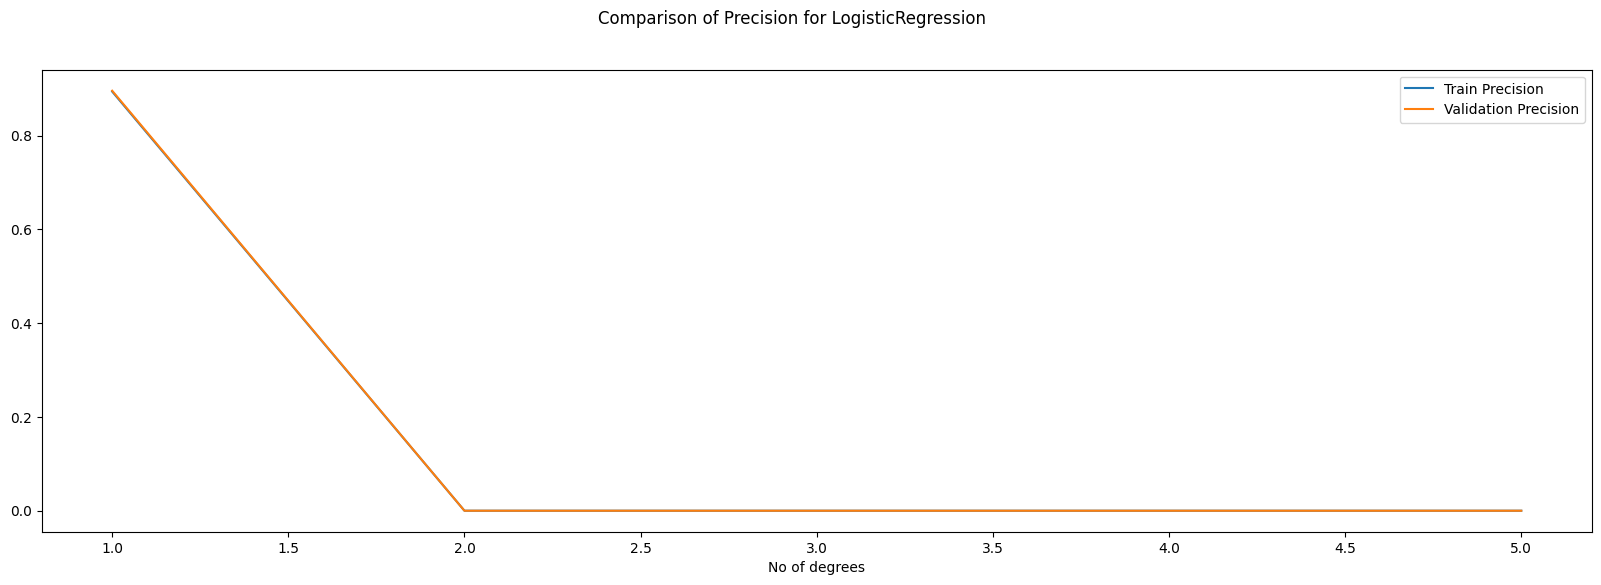

In [ ]:
fig,ax = plt.subplots(figsize=(20,6))

fig.suptitle('Comparison of Precision for LogisticRegression')

ax.plot(range(1,6),result['Precision_train'],label='Train Precision')
ax.plot(range(1,6),result['Precision_val'],label='Validation Precision')

ax.set_xlabel('No of degrees')


ax.legend()
plt.show()

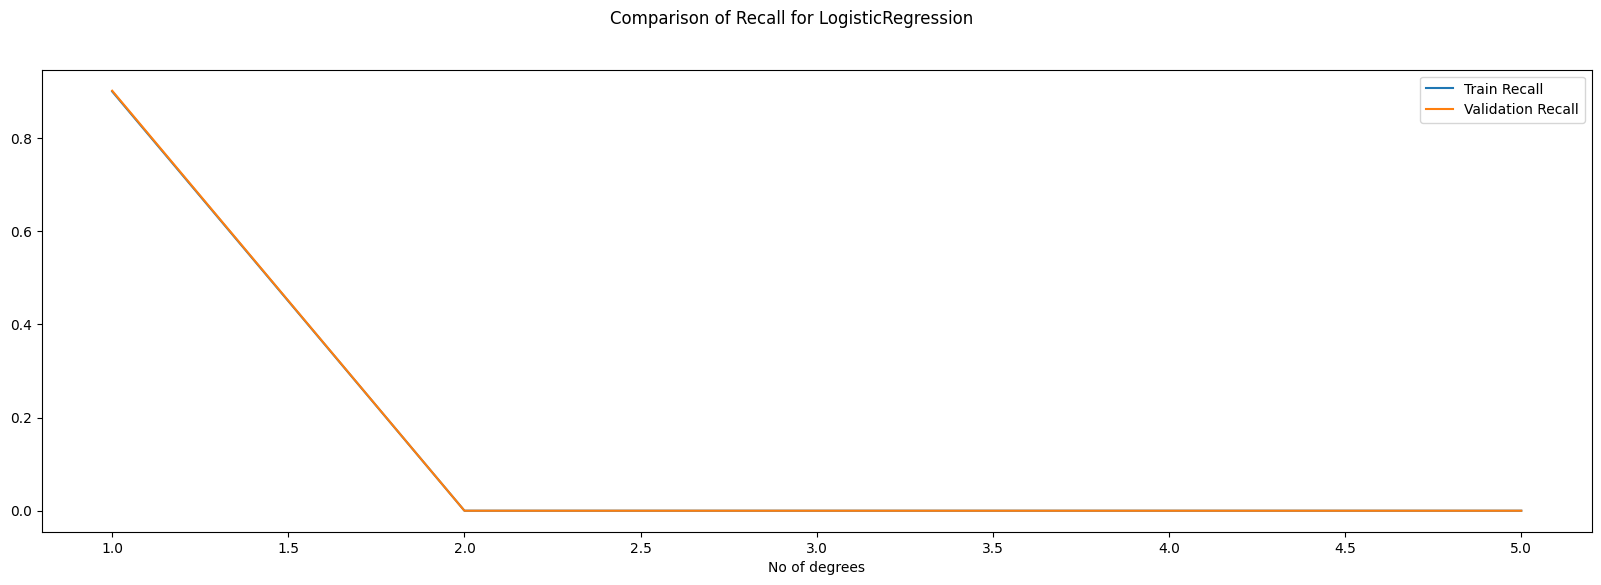

In [ ]:
fig,ax = plt.subplots(figsize=(20,6))

fig.suptitle('Comparison of Recall for LogisticRegression')

ax.plot(range(1,6),result['Recall_train'],label='Train Recall')
ax.plot(range(1,6),result['Recall_val'],label='Validation Recall')

ax.set_xlabel('No of degrees')


ax.legend()
plt.show()

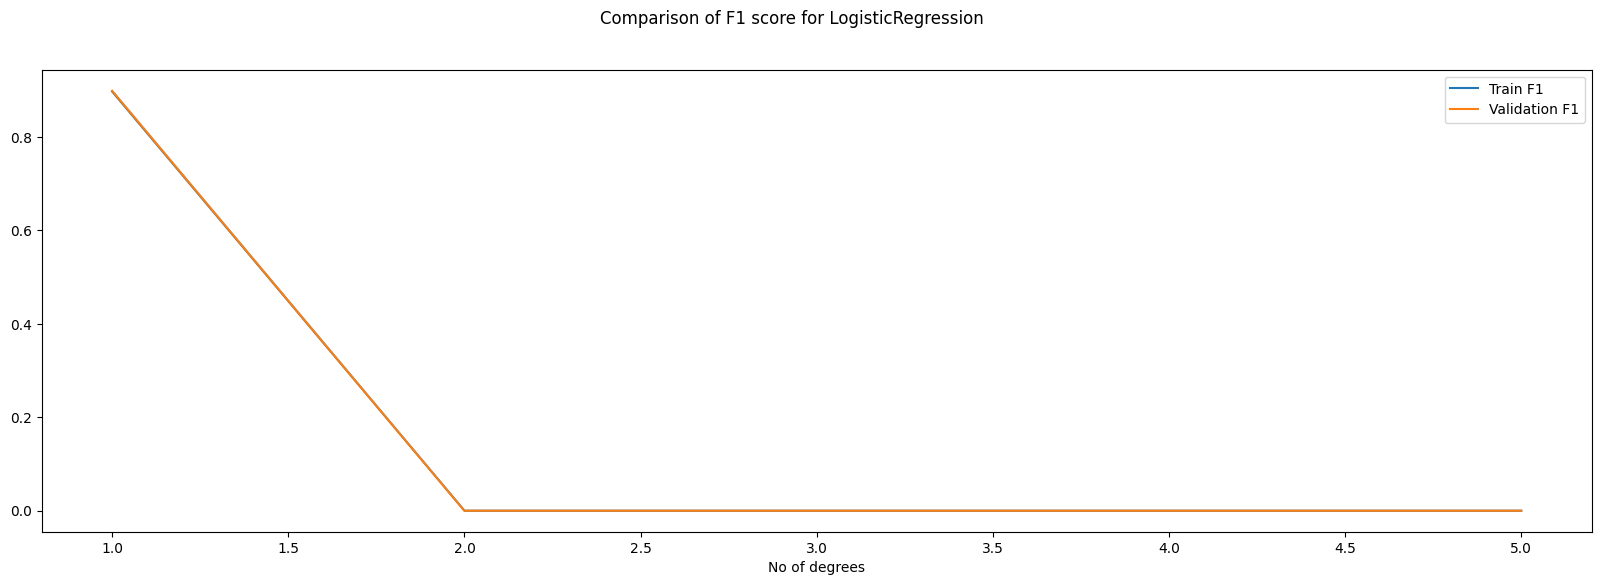

In [ ]:
fig,ax = plt.subplots(figsize=(20,6))

fig.suptitle('Comparison of F1 score for LogisticRegression')

ax.plot(range(1,6),result['F1_train'],label='Train F1')
ax.plot(range(1,6),result['F1_val'],label='Validation F1')

ax.set_xlabel('No of degrees')

ax.legend()
plt.show()

In [ ]:
knn = KNeighborsClassifier()
result = FindBestDegreeOfPolynomial(model=knn,,X_train=X_train,y_train=y_train,X_val=X_val,y_val=y_val)

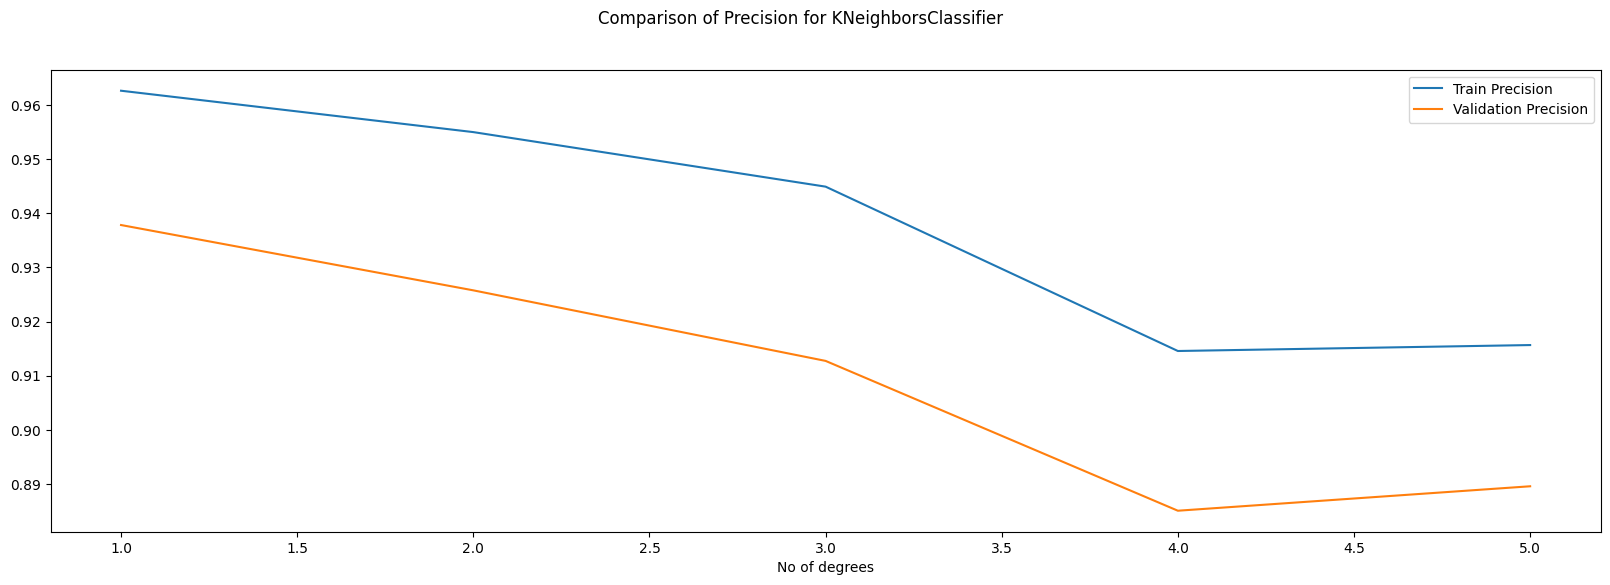

In [ ]:
fig,ax = plt.subplots(figsize=(20,6))

fig.suptitle('Comparison of Precision for KNeighborsClassifier')

ax.plot(range(1,6),result['Precision_train'],label='Train Precision')
ax.plot(range(1,6),result['Precision_val'],label='Validation Precision')

ax.set_xlabel('No of degrees')


ax.legend()
plt.show()

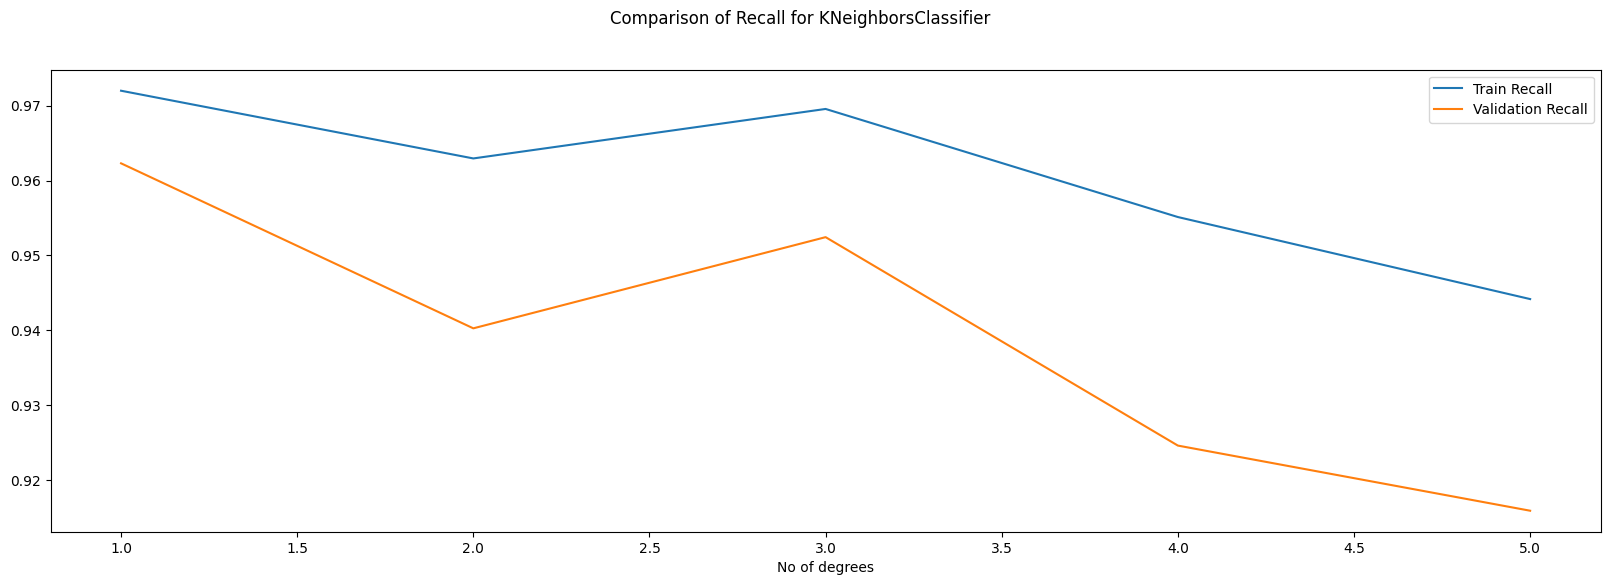

In [ ]:
fig,ax = plt.subplots(figsize=(20,6))

fig.suptitle('Comparison of Recall for KNeighborsClassifier')

ax.plot(range(1,6),result['Recall_train'],label='Train Recall')
ax.plot(range(1,6),result['Recall_val'],label='Validation Recall')

ax.set_xlabel('No of degrees')


ax.legend()
plt.show()

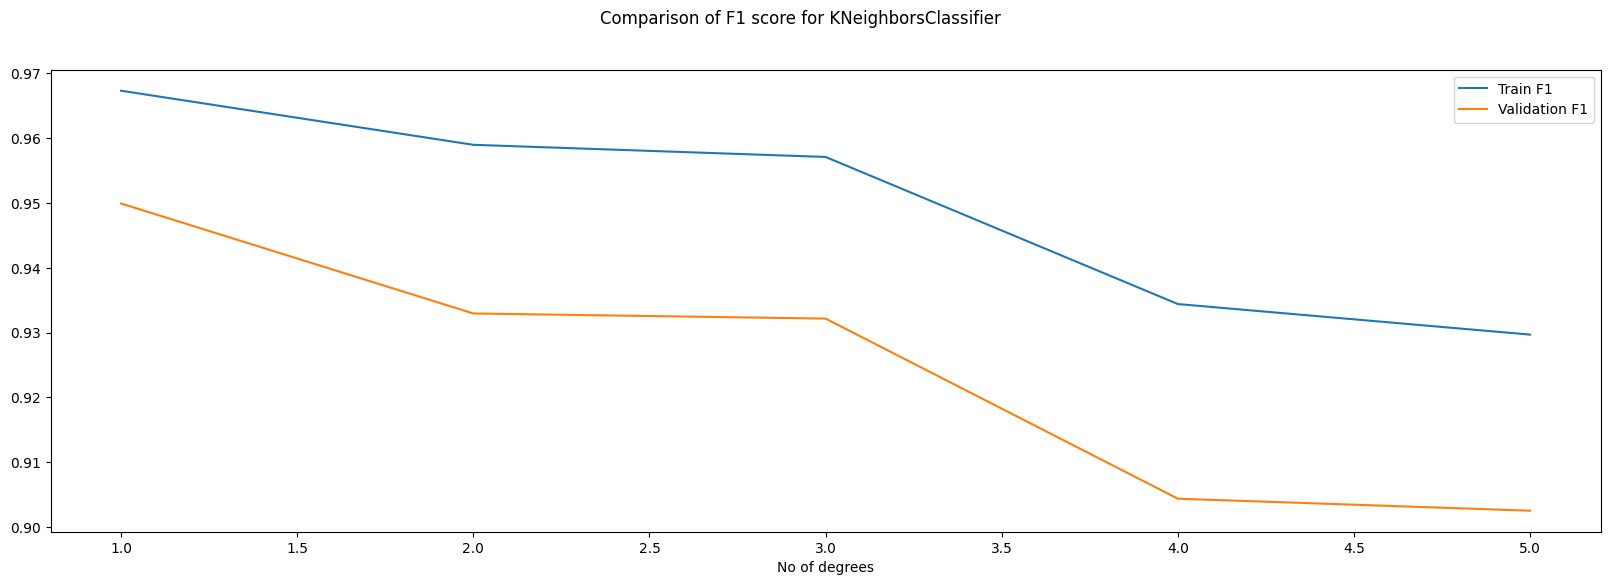

In [ ]:
fig,ax = plt.subplots(figsize=(20,6))

fig.suptitle('Comparison of F1 score for KNeighborsClassifier')

ax.plot(range(1,6),result['F1_train'],label='Train F1')
ax.plot(range(1,6),result['F1_val'],label='Validation F1')

ax.set_xlabel('No of degrees')

ax.legend()
plt.show()

In [ ]:
knn = KNeighborsClassifier()
result = FindBestDegreeOfPolynomial(model=knn,,X_train=X_train,y_train=y_train,X_val=X_val,y_val=y_val)

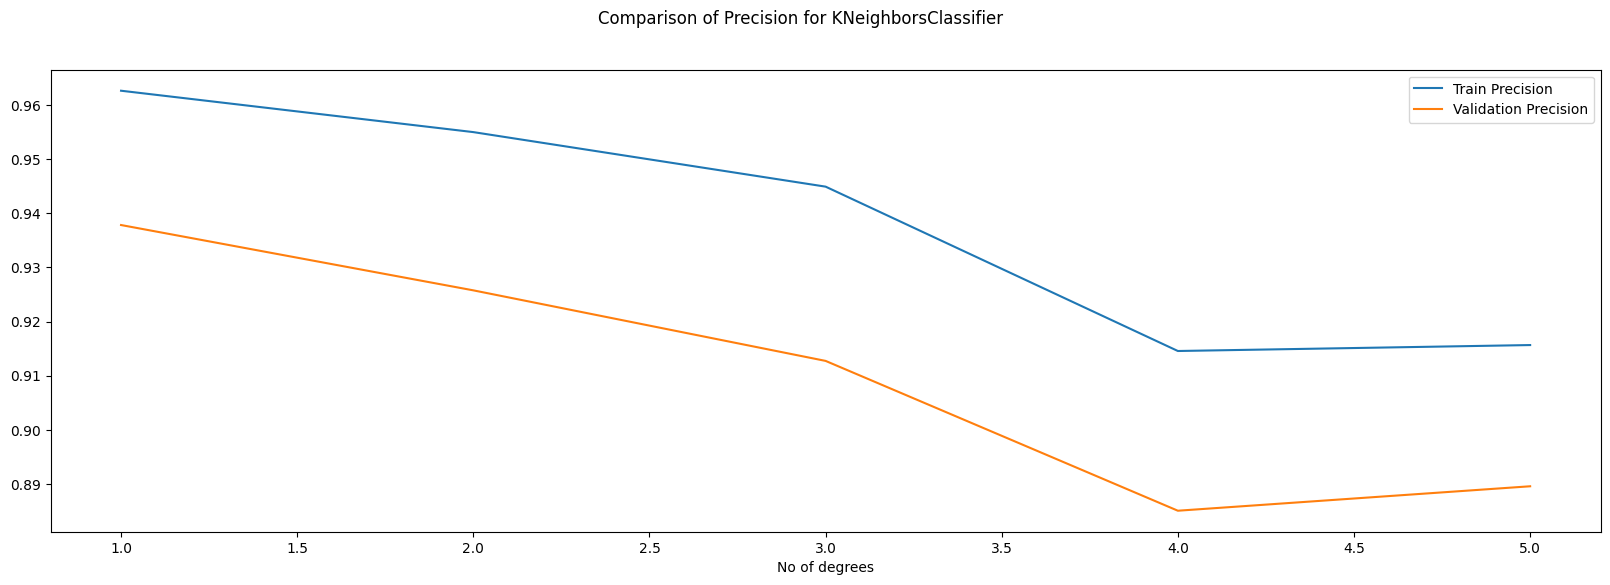

In [ ]:
fig,ax = plt.subplots(figsize=(20,6))

fig.suptitle('Comparison of Precision for KNeighborsClassifier')

ax.plot(range(1,6),result['Precision_train'],label='Train Precision')
ax.plot(range(1,6),result['Precision_val'],label='Validation Precision')

ax.set_xlabel('No of degrees')


ax.legend()
plt.show()

### 6.1. Experimentation with Polynmial Features Obserations

 - Polynomial Feature are not giving great results we are not going to use this technique

## 6.1.2 Experimentation with Feature Transformation

In [ ]:
def ShowFeatureAfterTransformation(feature=None,data=None,transformation=None):
  # Create a figure with 4 rows and 3 columns
  fig, ax = plt.subplots(3, 3, figsize=(20, 8), gridspec_kw={'height_ratios': [2, 0.5, 2]})

  fig.suptitle('Before and After transformation comaprision')

  # Plotting the first row
  sns.distplot(data[feature], ax=ax[0][0])
  sns.boxplot(data[feature], ax=ax[0][1])
  stats.probplot(data[feature], plot=ax[0][2])

  if transformation:

    sns.distplot(transformation(data[feature]+0.00001), ax=ax[2][0])
    sns.boxplot(transformation(data[feature]+0.00001), ax=ax[2][1])
    stats.probplot(transformation(data[feature]+0.00001), plot=ax[2][2])

  else:
    # Apply Yeo-Johnson transformation
    data, lmda = stats.yeojohnson(data[feature])

    # Plotting the second row with a gap
    sns.distplot(data, ax=ax[2][0])
    sns.boxplot(data, ax=ax[2][1])
    stats.probplot(data, plot=ax[2][2])


  ax[1, 0].axis('off')
  ax[1, 1].axis('off')
  ax[1, 2].axis('off')

  plt.show()


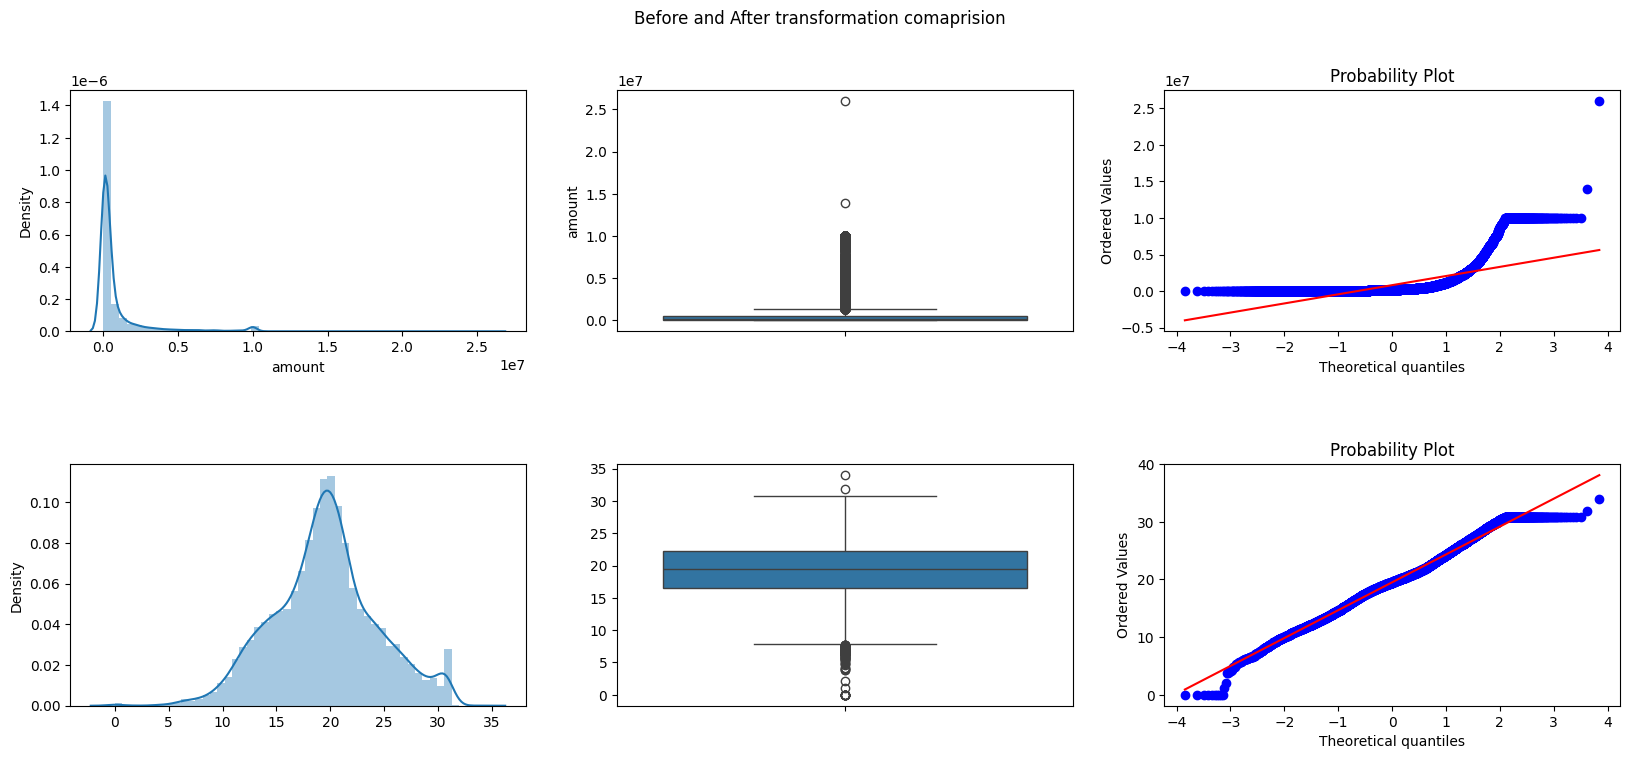

In [ ]:
ShowFeatureAfterTransformation('amount',X_train)

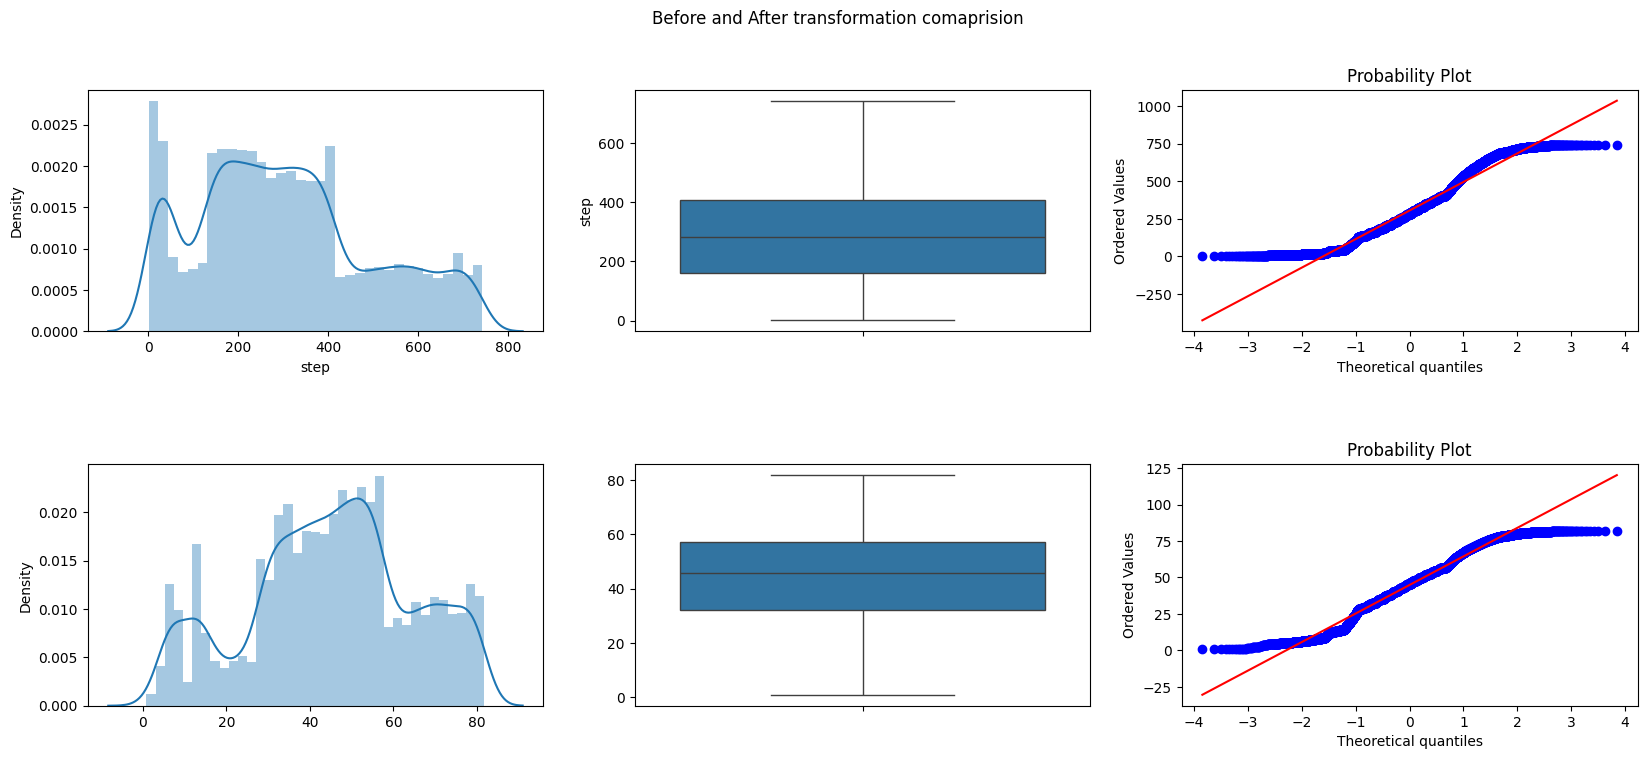

In [ ]:
ShowFeatureAfterTransformation('step',X_train)

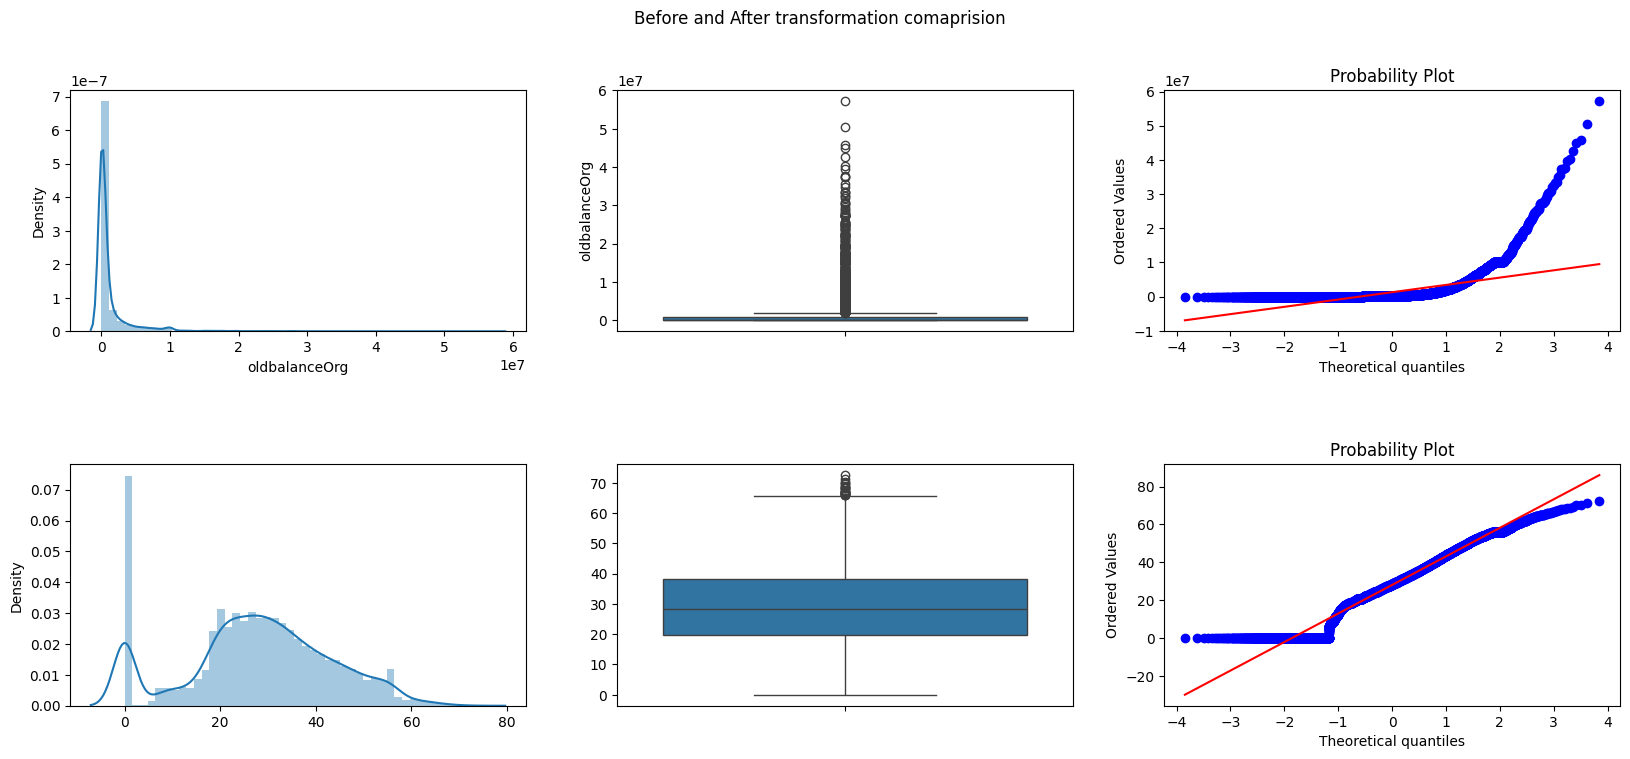

In [ ]:
ShowFeatureAfterTransformation('oldbalanceOrg',X_train)

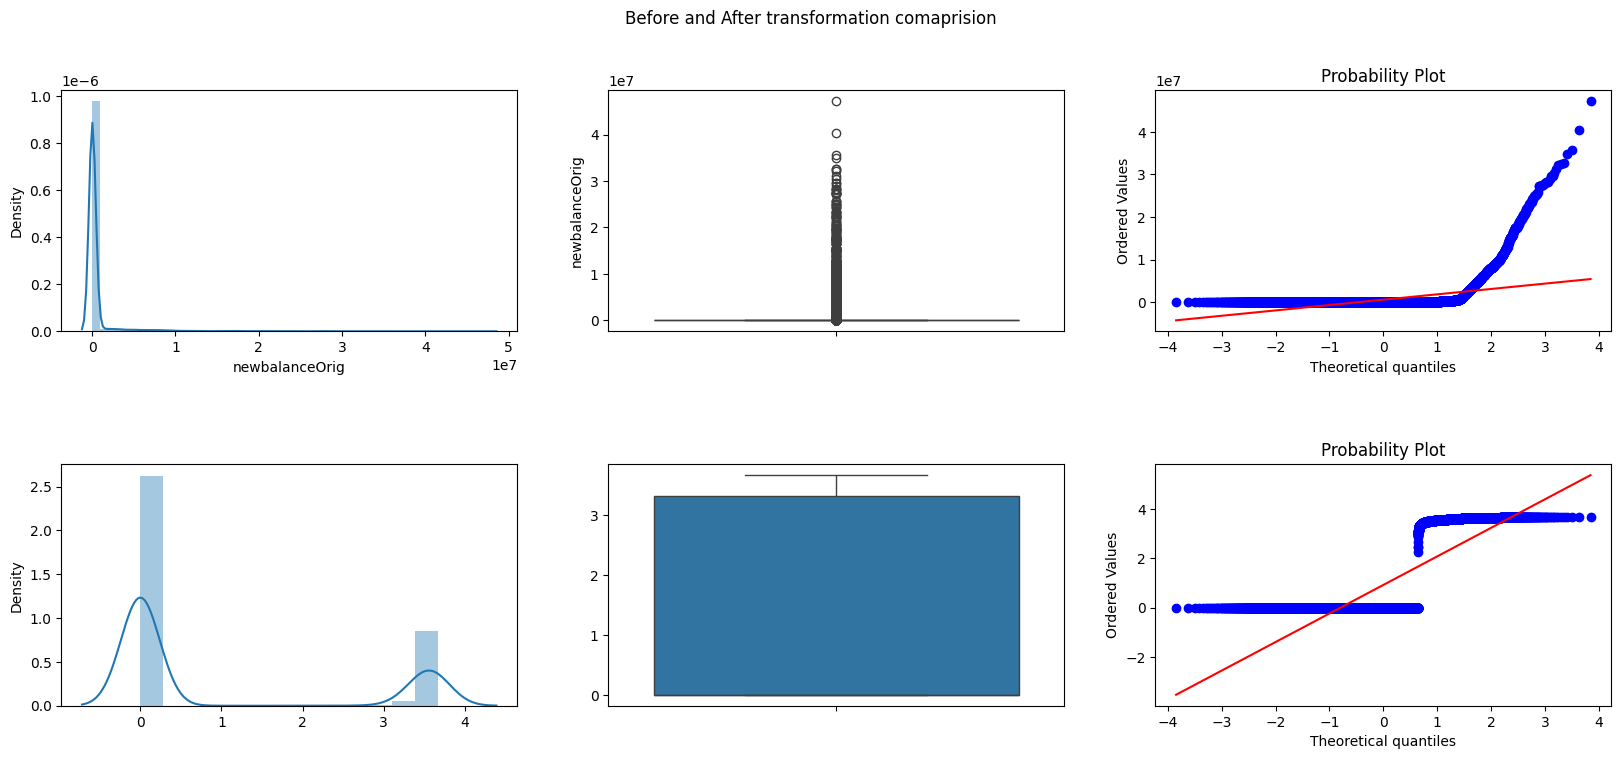

In [ ]:
ShowFeatureAfterTransformation('newbalanceOrig',X_train)

In [ ]:
# Transform selected features using the Yeo-Johnson transformation and create a new DataFrame
X_train_transformed = X_train.assign(
    step_transformed = stats.yeojohnson(X_train['step'])[0],  # Transform 'step' feature
    amount_transformed = stats.yeojohnson(X_train['amount'])[0],  # Transform 'amount' feature
    oldbalanceOrg_transformed = stats.yeojohnson(X_train['oldbalanceOrg'])[0],  # Transform 'oldbalanceOrg' feature
    newbalanceOrig_transformed = stats.yeojohnson(X_train['newbalanceOrig'])[0],  # Transform 'newbalanceOrig' feature
    newbalanceDest_transformed = stats.yeojohnson(X_train['newbalanceDest'])[0],  # Transform 'newbalanceDest' feature
    oldbalanceDest_transformed = stats.yeojohnson(X_train['oldbalanceDest'])[0]  # Transform 'oldbalanceDest' feature
).drop(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'newbalanceDest', 'oldbalanceDest'], axis=1)


<Axes: >

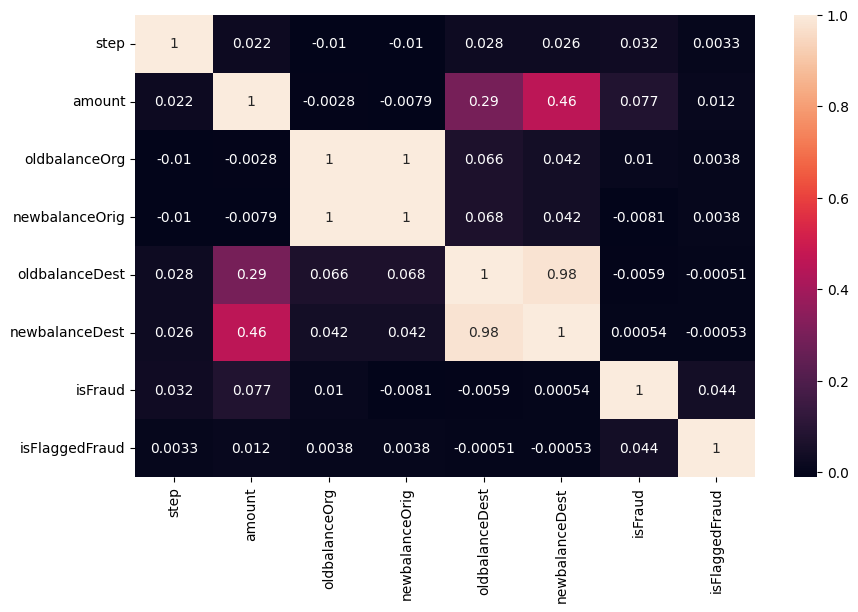

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),annot=True)

<Axes: >

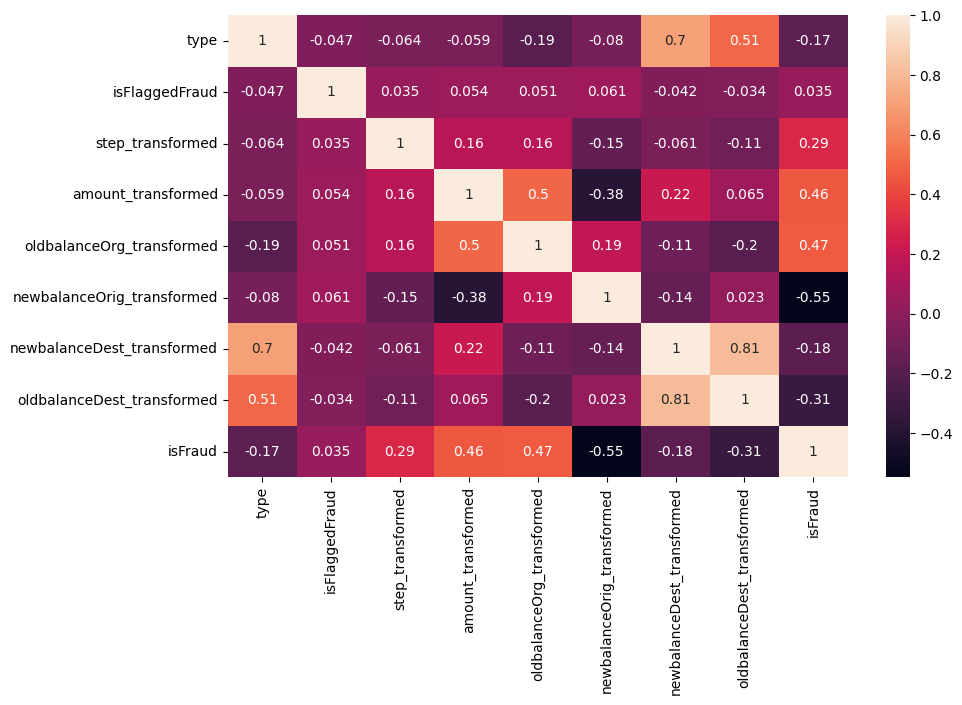

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(pd.concat([X_train_transformed,y_train],axis=1).corr(),annot=True)

### 6.1.2. Experimentation with Features Transformation Obserations

 - As per observation when we applied the Yeojohnson Transformation we can see feature like Step and Amount improves correlation with target column isFraud

 - There are increase in other feature correlation with target columns


| Feature Name   | Before   | After   |
| -------------- | -------- | ------- |
| Step           | 0.0033   | 0.29    |
| Amount         | 0.012    | 0.46    |
| oldbalanceOrg  | 0.0038   | 0.47    |
| newbalanceOrg  | 0.0038   | - 0.54    |


# 7. Handling Multicolinearity and Statistical Testing.

  ***Plan of actions***

  - We are going to use Mutual Information technique to choose best 7-8 features.
  -We use SmartCorrelatedSelection method of feature-engine to remove multi-colinearity

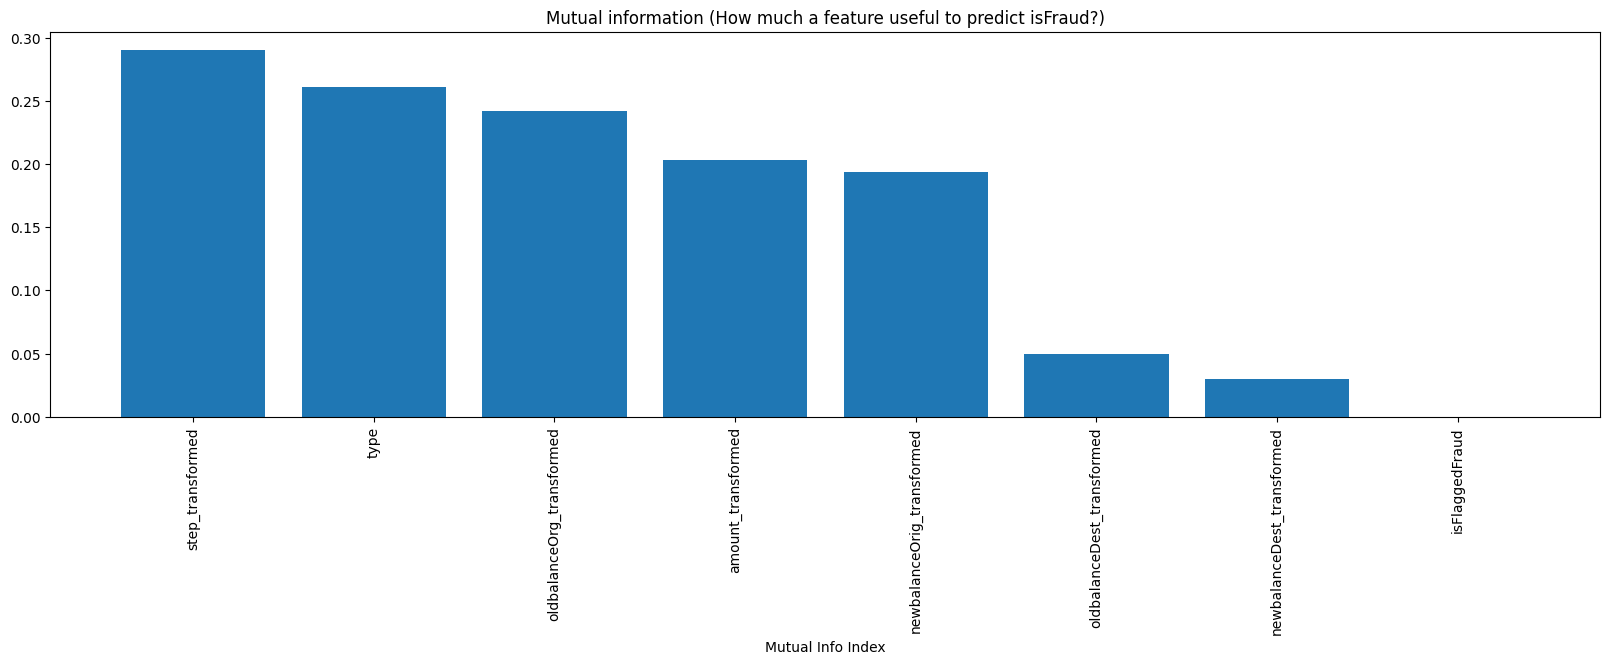

In [ ]:
# Calculate Mutual Information between each feature and the target variable
mic = mutual_info_classif(X_train_transformed, y_train)

# Create a Series to store the Mutual Information values with feature names as indices
mic_series = pd.Series(mic)

# Set feature names as indices for better readability
mic_series.index = X_train_transformed.columns

# Sort the Series in descending order based on Mutual Information values
mic_series = mic_series.sort_values(ascending=False)

# Create a bar plot to visualize Mutual Information values for each feature
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('Mutual Information (How much a feature is useful to predict isFraud?)')
ax.bar(mic_series.index, mic_series.values)
ax.set_xlabel('Feature Names')
ax.set_ylabel('Mutual Info Index')  # Fix: Use set_ylabel instead of set_xlabel
plt.xticks(rotation=90)
plt.show()

In [ ]:
selector = SelectKBest(mutual_info_classif, k=7)

# Fit the training data
selector.fit(X_train_transformed,y_train)

SelectKBest(k=7, score_func=<function mutual_info_classif at 0x78c693b38940>)

In [ ]:
X_example = selector.fit_transform(X_train_transformed,y_train)

In [ ]:
Selected_Features = list(X_train_transformed.columns[list(selector.get_support())])

<Axes: >

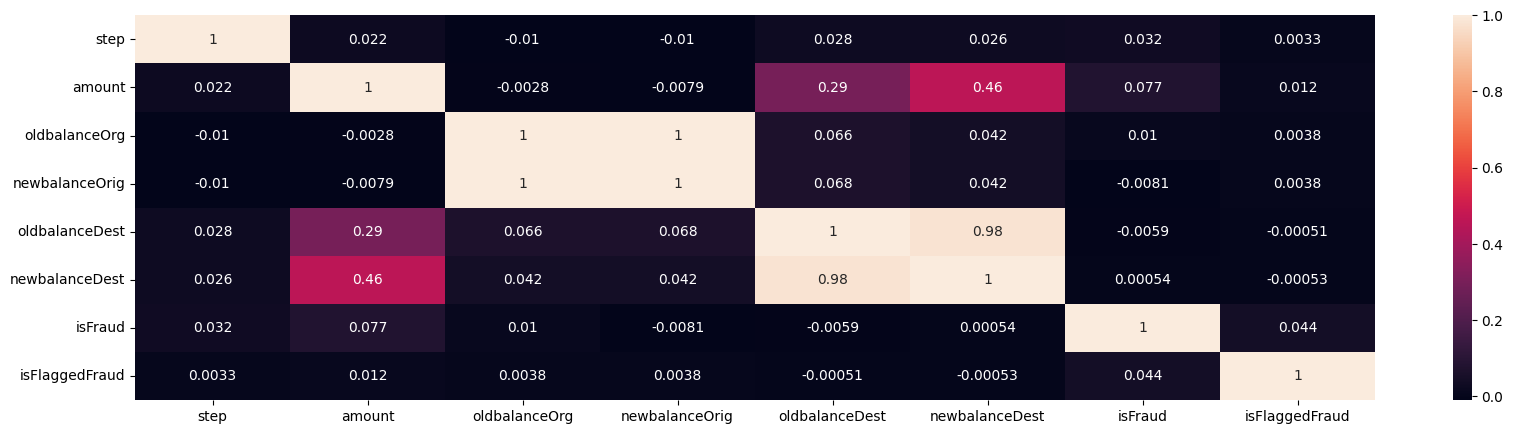

In [ ]:
plt.figure(figsize=(20,5))
sns.heatmap(df.corr(),annot=True)

<Axes: >

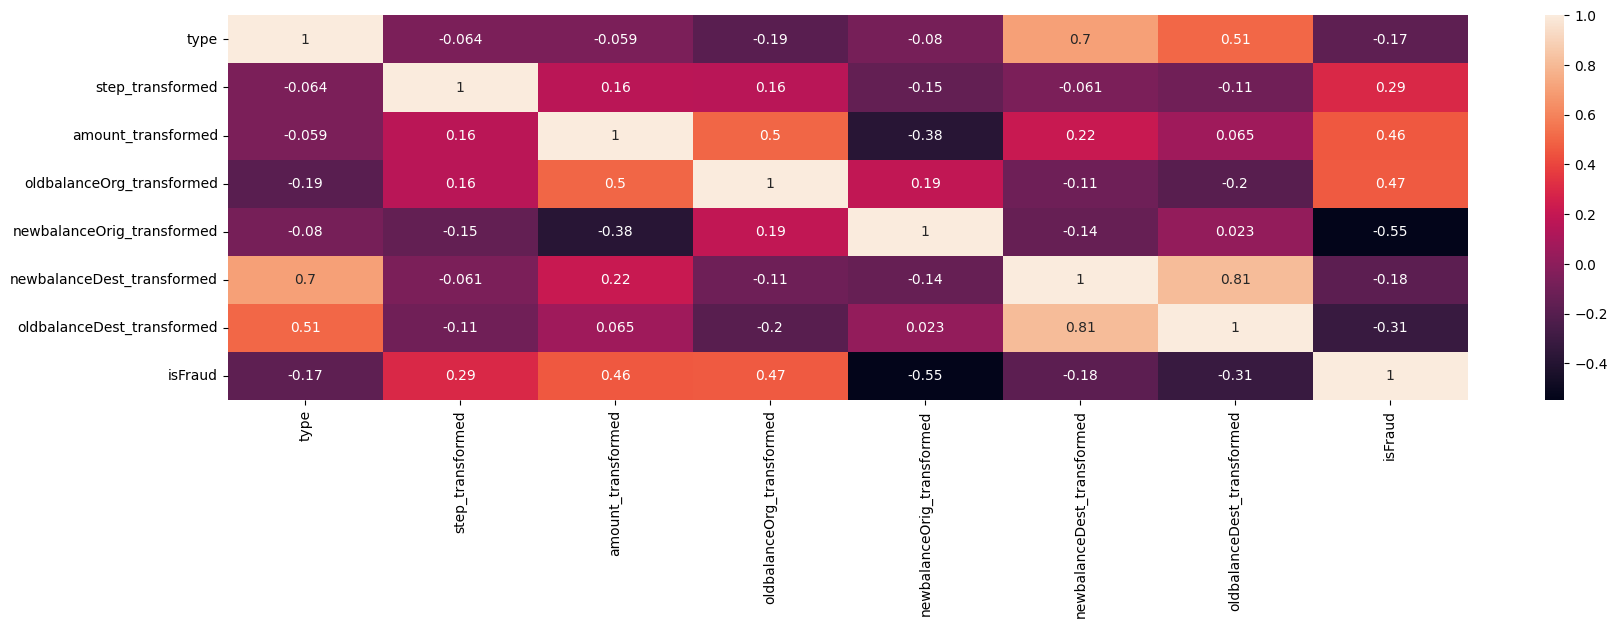

In [ ]:
plt.figure(figsize=(20,5))
sns.heatmap(pd.concat([X_train_transformed[Selected_Features],y_train],axis=1).corr(),annot=True)

In [ ]:
scs = SmartCorrelatedSelection(threshold=0.6)
scs_X_train_transformed = scs.fit_transform(X_train_transformed)

In [ ]:
[feature for feature in X_train_transformed.columns if feature not in scs_X_train_transformed.columns]

['newbalanceDest_transformed']

<Axes: >

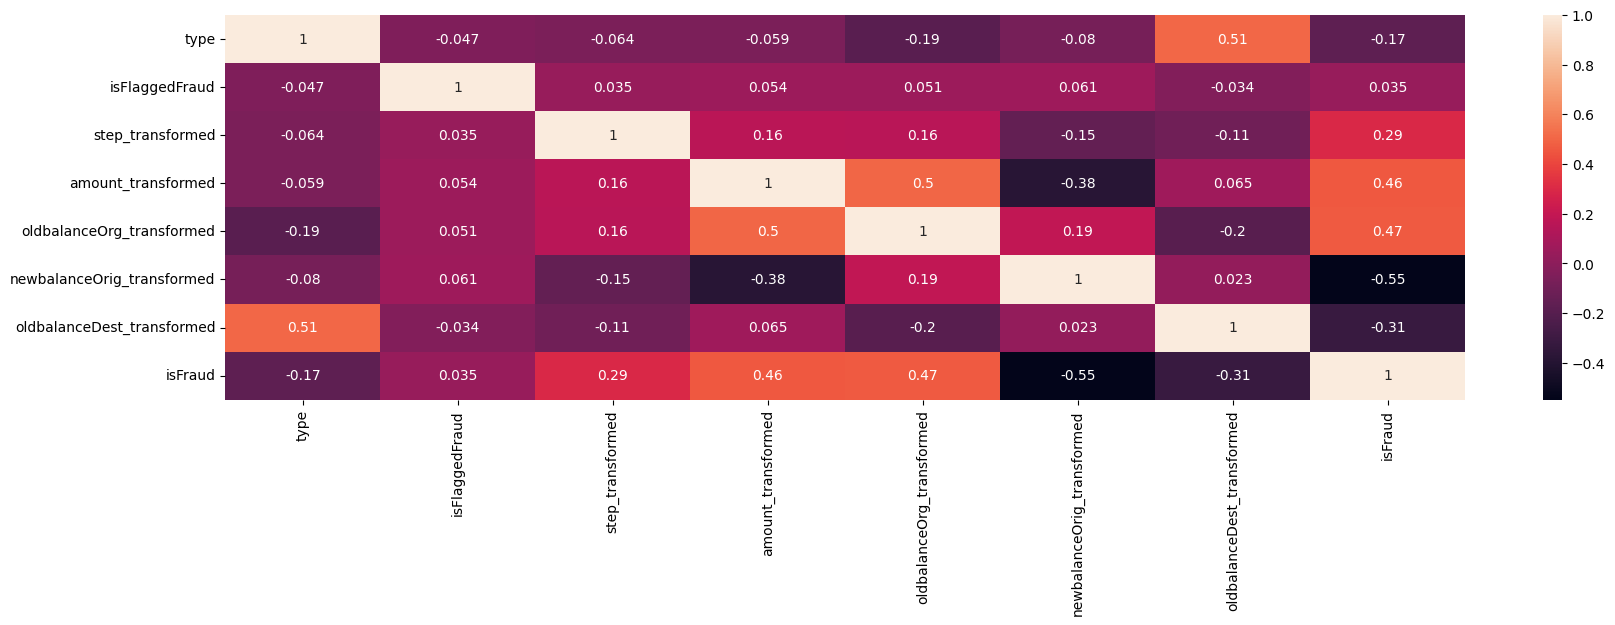

In [ ]:
plt.figure(figsize=(20,5))
sns.heatmap(pd.concat([scs_X_train_transformed,y_train],axis=1).corr(),annot=True)

# 8. Putting all Together using pipeline and functions

In [ ]:
def ShowPerformanceMetrics(pipe=None, X_train=None, y_train=None, X_val=None, y_val=None):
    """
    Display performance metrics including confusion matrix, classification report,
    precision, recall, and F1 score for the training and validation sets.

    Parameters:
    - pipe (Pipeline): The fitted scikit-learn pipeline containing the model.
    - X_train (DataFrame): Feature matrix of the training set.
    - y_train (Series): Target variable of the training set.
    - X_val (DataFrame): Feature matrix of the validation set.
    - y_val (Series): Target variable of the validation set.

    Returns:
    None
    """

    # Make predictions on the validation set and training set
    X_train_pred = pipe.predict(X_train)
    val_pred = pipe.predict(X_val)

    # Display confusion matrix
    print('************Confusion Matrix****************')
    print('Training Data')
    display(pd.DataFrame(confusion_matrix(y_train, X_train_pred), index=['0', '1'], columns=['0', '1']))
    print()
    print('Validation Data')
    display(pd.DataFrame(confusion_matrix(y_val, val_pred), index=['0', '1'], columns=['0', '1']))

    # Display classification report
    print('*************Classification Report************')
    print('Training Data')
    print(classification_report(y_train, X_train_pred))
    print()
    print('Validation Data')
    print(classification_report(y_val, val_pred))
    print()

    # Display precision and recall scores
    print('************Training Performance Metrics***********\n')
    print(f'Precision: {precision_score(y_train, X_train_pred)}\nRecall: {recall_score(y_train, X_train_pred)}\nF1 Score: {f1_score(y_train, X_train_pred)}\n')

    print('************Validation Performance Metrics***********\n')
    print(f'Precision: {precision_score(y_val, val_pred)}\nRecall: {recall_score(y_val, val_pred)}\nF1 Score: {f1_score(y_val, val_pred)}\n')


In [8]:
def DataPreprocesor(data):
    """
    Preprocess the input data by removing rows with specific conditions (have 0.0 in both independent and target column) and handling class imbalance.

    Parameters:
    - data (DataFrame): Input dataframe containing the transaction data.

    Returns:
    - X_resampled (DataFrame): Resampled feature matrix after preprocessing.
    - y_resampled (Series): Resampled target variable after preprocessing.
    """

    # Identify indexes of rows with zero balances and non-fraudulent transactions
    oldbalanceOrgZeroIndexes = set(data.query('oldbalanceOrg == 0.0 & isFraud == 0').index)
    newbalanceOrigZeroIndexes = set(data.query('newbalanceOrig == 0.0 & isFraud == 0').index)
    oldbalanceDestZeroIndexes = set(data.query('oldbalanceDest == 0.0 & isFraud == 0').index)
    newbalanceDestZeroIndexes = set(data.query('newbalanceDest == 0.0 & isFraud == 0').index)

    # Identify indexes of rows with zero balances in all specified columns
    ZeroIndexes = oldbalanceOrgZeroIndexes.intersection(newbalanceOrigZeroIndexes,
                                                        oldbalanceDestZeroIndexes,
                                                        newbalanceDestZeroIndexes)

    # Drop rows with zero balances and non-fraudulent transactions
    NonZeroDf = data.drop(list(ZeroIndexes), axis=0)

    # Separate features and target variable
    X, y = NonZeroDf.drop('isFraud', axis=1), NonZeroDf['isFraud']

    # Resample the data to address class imbalance using RandomUnderSampler
    rus = RandomUnderSampler()
    X_resampled, y_resampled = rus.fit_resample(X, y)

    # Remove High cardinal columns
    X_resampled.drop(['nameOrig',	'nameDest'],axis=1,inplace=True)

    return X_resampled, y_resampled


In [13]:
def ModelPipeline(model=None, scaler=None):
    """
    Create a scikit-learn pipeline for model training and prediction.

    Parameters:
    - model: The machine learning model to be used.
    - scaler: The scaler method for feature scaling.

    Returns:
    - pipe: The scikit-learn pipeline containing the specified operations.
    """

    # Define a sequence of operations in the pipeline
    Operations = [
        # Encode categorical feature into frequency
        ('CountFrequencyEncoder', CountFrequencyEncoder(variables=['type'], encoding_method='frequency')),

        # Transform and handle outliers using Yeo-Johnson transformation
        ('YeoJohnsonTransformer', YeoJohnsonTransformer(variables=['step', 'amount', 'oldbalanceOrg',
                                                                     'newbalanceOrig', 'newbalanceDest', 'oldbalanceDest'])),

        # Select top 7 features based on mutual information
        ('SelectTop7Features', SelectKBest(mutual_info_classif, k=7)),

        # Remove multi-collinearity
        ('SelectLessCorrelatedFeatures', SmartCorrelatedSelection(threshold=0.6)),

        # Scale data using the specified scaler
        ('FeatureScaling', scaler()),

        # Include the model
        ('Model', model())
    ] if model else [
        # Encode categorical feature into frequency
        ('CountFrequencyEncoder', CountFrequencyEncoder(variables=['type'], encoding_method='frequency')),

        # Transform and handle outliers using Yeo-Johnson transformation
        ('YeoJohnsonTransformer', YeoJohnsonTransformer(variables=['step', 'amount', 'oldbalanceOrg',
                                                                     'newbalanceOrig', 'newbalanceDest', 'oldbalanceDest'])),

        # Select top 7 features based on mutual information
        ('SelectTop7Features', SelectKBest(mutual_info_classif, k=7)),

        # Remove multi-collinearity
        ('SelectLessCorrelatedFeatures', SmartCorrelatedSelection(threshold=0.6)),

        # Scale data using the specified scaler
        ('FeatureScaling', scaler()),
    ]

    # Create a scikit-learn pipeline
    pipe = Pipeline(Operations)

    return pipe

In [9]:
X_resampled, y_resampled = DataPreprocesor(df)

In [10]:
X_train, X_other, y_train, y_other = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=101, stratify=y_resampled)
X_val, X_test, y_val, y_test = train_test_split(X_other, y_other, test_size=0.3, random_state=101, stratify=y_other)

In [ ]:
pipe = ModelPipeline(LogisticRegression,StandardScaler)
pipe.fit(X_train,y_train)

Pipeline(steps=[('CountFrequencyEncoder',
                 CountFrequencyEncoder(encoding_method='frequency',
                                       variables=['type'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['step', 'amount',
                                                  'oldbalanceOrg',
                                                  'newbalanceOrig',
                                                  'newbalanceDest',
                                                  'oldbalanceDest'])),
                ('SelectTop7Features',
                 SelectKBest(k=7,
                             score_func=<function mutual_info_classif at 0x78c693b38940>)),
                ('SelectLessCorrelatedFeatures',
                 SmartCorrelatedSelection(threshold=0.6)),
                ('FeatureScaling', StandardScaler()),
                ('Model', LogisticRegression())])

In [ ]:
print('************Logistic LogisticRegression Performance************')
ShowPerformanceMetrics(pipe=pipe,X_train=X_train,y_train=y_train,X_val=X_val,y_val=y_val)

************Logistic LogisticRegression Performance************
************Confusion Matrix****************
Training Data


,0,1
0,5303,446
1,290,5459



Validation Data


,0,1
0,1559,166
1,86,1638


*************Classification Report************
Training Data
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      5749
           1       0.92      0.95      0.94      5749

    accuracy                           0.94     11498
   macro avg       0.94      0.94      0.94     11498
weighted avg       0.94      0.94      0.94     11498


Validation Data
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      1725
           1       0.91      0.95      0.93      1724

    accuracy                           0.93      3449
   macro avg       0.93      0.93      0.93      3449
weighted avg       0.93      0.93      0.93      3449


************Training Performance Metrics***********

Precision: 0.9244707874682473
Recall: 0.9495564445990607
F1 Score: 0.9368457182083406

************Validation Performance Metrics***********

Precision: 0.9079822616407982
Recall: 0.9501160092807425
F1 Score: 0.928

In [ ]:
pipe = ModelPipeline(SVC,StandardScaler)
pipe.fit(X_train,y_train)

Pipeline(steps=[('CountFrequencyEncoder',
                 CountFrequencyEncoder(encoding_method='frequency',
                                       variables=['type'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['step', 'amount',
                                                  'oldbalanceOrg',
                                                  'newbalanceOrig',
                                                  'newbalanceDest',
                                                  'oldbalanceDest'])),
                ('SelectTop7Features',
                 SelectKBest(k=7,
                             score_func=<function mutual_info_classif at 0x78c693b38940>)),
                ('SelectLessCorrelatedFeatures',
                 SmartCorrelatedSelection(threshold=0.6)),
                ('FeatureScaling', StandardScaler()), ('Model', SVC())])

In [ ]:
print('************Support Vector Classifier Performance************')
ShowPerformanceMetrics(pipe=pipe,X_train=X_train,y_train=y_train,X_val=X_val,y_val=y_val)

************Support Vector Classifier Performance************
************Confusion Matrix****************
Training Data


,0,1
0,5519,230
1,29,5720



Validation Data


,0,1
0,1653,72
1,4,1720


*************Classification Report************
Training Data
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      5749
           1       0.96      0.99      0.98      5749

    accuracy                           0.98     11498
   macro avg       0.98      0.98      0.98     11498
weighted avg       0.98      0.98      0.98     11498


Validation Data
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1725
           1       0.96      1.00      0.98      1724

    accuracy                           0.98      3449
   macro avg       0.98      0.98      0.98      3449
weighted avg       0.98      0.98      0.98      3449


************Training Performance Metrics***********

Precision: 0.9613445378151261
Recall: 0.994955644459906
F1 Score: 0.977861355671425

************Validation Performance Metrics***********

Precision: 0.9598214285714286
Recall: 0.9976798143851509
F1 Score: 0.97838

In [ ]:
pipe = ModelPipeline(KNeighborsClassifier,StandardScaler)
pipe.fit(X_train,y_train)

Pipeline(steps=[('CountFrequencyEncoder',
                 CountFrequencyEncoder(encoding_method='frequency',
                                       variables=['type'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['step', 'amount',
                                                  'oldbalanceOrg',
                                                  'newbalanceOrig',
                                                  'newbalanceDest',
                                                  'oldbalanceDest'])),
                ('SelectTop7Features',
                 SelectKBest(k=7,
                             score_func=<function mutual_info_classif at 0x78c693b38940>)),
                ('SelectLessCorrelatedFeatures',
                 SmartCorrelatedSelection(threshold=0.6)),
                ('FeatureScaling', StandardScaler()),
                ('Model', KNeighborsClassifier())])

In [ ]:
print('************KNeighborsClassifier Performance************')
ShowPerformanceMetrics(pipe=pipe,X_train=X_train,y_train=y_train,X_val=X_val,y_val=y_val)

************KNeighborsClassifier Performance************
************Confusion Matrix****************
Training Data


,0,1
0,5588,161
1,54,5695



Validation Data


,0,1
0,1648,77
1,26,1698


*************Classification Report************
Training Data
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5749
           1       0.97      0.99      0.98      5749

    accuracy                           0.98     11498
   macro avg       0.98      0.98      0.98     11498
weighted avg       0.98      0.98      0.98     11498


Validation Data
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1725
           1       0.96      0.98      0.97      1724

    accuracy                           0.97      3449
   macro avg       0.97      0.97      0.97      3449
weighted avg       0.97      0.97      0.97      3449


************Training Performance Metrics***********

Precision: 0.9725068306010929
Recall: 0.9906070620977562
F1 Score: 0.981473502800517

************Validation Performance Metrics***********

Precision: 0.9566197183098591
Recall: 0.9849187935034803
F1 Score: 0.9705

## 8.1. Putting all Together using pipeline and functions observations

  ***Evaluation Metrics***

***Precision***:
- High precision indicates accurate positive predictions.
- Useful when the cost of false positives is high.

***Recall (Sensitivity or True Positive Rate)***:
- High recall indicates effective capture of actual positive instances.
- Important when the cost of false negatives is high.

***F1 Score***:
- High F1 score indicates a good balance between precision and recall.
- Useful when there is an imbalance between the classes or when both false positives and false negatives are costly.




## 8.1.1 Model Performance Comparison

### Logistic Regression Performance

**Training Performance Metrics:**
- Precision: 0.9245
- Recall: 0.9496
- F1 Score: 0.9368

**Validation Performance Metrics:**
- Precision: 0.9080
- Recall: 0.9501
- F1 Score: 0.9286

---

### Support Vector Classifier Performance

**Training Performance Metrics:**
- Precision: 0.9613
- Recall: 0.9950
- F1 Score: 0.9779

**Validation Performance Metrics:**
- Precision: 0.9598
- Recall: 0.9977
- F1 Score: 0.9784

---

### KNeighborsClassifier Performance

**Training Performance Metrics:**
- Precision: 0.9725
- Recall: 0.9906
- F1 Score: 0.9815

**Validation Performance Metrics:**
- Precision: 0.9566
- Recall: 0.9849
- F1 Score: 0.9706

---

### Top 2 Models (Based on F1 Score)

1. **Support Vector Classifier:**
   - Training F1 Score: 0.9779
   - Validation F1 Score: 0.9784

2. **KNeighborsClassifier:**
   - Training F1 Score: 0.9815
   - Validation F1 Score: 0.9706


# 9. Fine Tuning Models Performance
  - To get best performance
  - To reduce overfitting
  - To optimize training

In [ ]:
pipe = ModelPipeline(KNeighborsClassifier,StandardScaler)

# KNN parameters
Params = {
          'Model__n_neighbors':list(range(1,20)),
          'Model__weights':['uniform','distance']
         }

GridSCV = GridSearchCV(pipe,Params,scoring='f1',cv=5)

In [ ]:
result = GridSCV.fit(X_train,y_train)

In [ ]:
result.best_params_

{'Model__n_neighbors': 4, 'Model__weights': 'distance'}

In [ ]:
result.best_score_

0.9747341970576407

In [ ]:
best_model = result.best_estimator_

In [ ]:
ShowPerformanceMetrics(best_model,X_train,y_train,X_val,y_val)

************Confusion Matrix****************
Training Data


,0,1
0,5749,0
1,0,5749



Validation Data


,0,1
0,1657,68
1,25,1699


*************Classification Report************
Training Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5749
           1       1.00      1.00      1.00      5749

    accuracy                           1.00     11498
   macro avg       1.00      1.00      1.00     11498
weighted avg       1.00      1.00      1.00     11498


Validation Data
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1725
           1       0.96      0.99      0.97      1724

    accuracy                           0.97      3449
   macro avg       0.97      0.97      0.97      3449
weighted avg       0.97      0.97      0.97      3449


************Training Performance Metrics***********

Precision: 1.0
Recall: 1.0
F1 Score: 1.0

************Validation Performance Metrics***********

Precision: 0.9615166949632145
Recall: 0.9854988399071926
F1 Score: 0.9733600687482096



In [ ]:
ShowPerformanceMetrics(best_model,X_train,y_train,X_test,y_test)

************Confusion Matrix****************
Training Data


,0,1
0,5749,0
1,0,5749



Validation Data


,0,1
0,706,33
1,7,733


*************Classification Report************
Training Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5749
           1       1.00      1.00      1.00      5749

    accuracy                           1.00     11498
   macro avg       1.00      1.00      1.00     11498
weighted avg       1.00      1.00      1.00     11498


Validation Data
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       739
           1       0.96      0.99      0.97       740

    accuracy                           0.97      1479
   macro avg       0.97      0.97      0.97      1479
weighted avg       0.97      0.97      0.97      1479


************Training Performance Metrics***********

Precision: 1.0
Recall: 1.0
F1 Score: 1.0

************Validation Performance Metrics***********

Precision: 0.9569190600522193
Recall: 0.9905405405405405
F1 Score: 0.9734395750332006



In [ ]:
best_model

Pipeline(steps=[('CountFrequencyEncoder',
                 CountFrequencyEncoder(encoding_method='frequency',
                                       variables=['type'])),
                ('YeoJohnsonTransformer',
                 YeoJohnsonTransformer(variables=['step', 'amount',
                                                  'oldbalanceOrg',
                                                  'newbalanceOrig',
                                                  'newbalanceDest',
                                                  'oldbalanceDest'])),
                ('SelectTop7Features',
                 SelectKBest(k=7,
                             score_func=<function mutual_info_classif at 0x78c693b38940>)),
                ('SelectLessCorrelatedFeatures',
                 SmartCorrelatedSelection(threshold=0.6)),
                ('FeatureScaling', StandardScaler()),
                ('Model',
                 KNeighborsClassifier(n_neighbors=4, weights='distance'))])

In [ ]:
pipe = ModelPipeline(SVC,StandardScaler)

# KNN parameters
Params = {
          'Model__C':np.linspace(0.1,1,10),
          'Model__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
          'Model__gamma':['auto','scale']
         }

GridSCV = GridSearchCV(pipe,Params,scoring='f1',cv=5)

In [ ]:
scv_result = GridSCV.fit(X_train,y_train)

In [ ]:
scv_result.best_params_

{'Model__C': 1.0, 'Model__gamma': 'auto', 'Model__kernel': 'rbf'}

In [ ]:
scv_result.best_score_

0.9770355868717779

In [ ]:
scv_model = result.best_estimator_

In [ ]:
ShowPerformanceMetrics(scv_model,X_train,y_train,X_val,y_val)

************Confusion Matrix****************
Training Data


,0,1
0,5749,0
1,0,5749



Validation Data


,0,1
0,1657,68
1,25,1699


*************Classification Report************
Training Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5749
           1       1.00      1.00      1.00      5749

    accuracy                           1.00     11498
   macro avg       1.00      1.00      1.00     11498
weighted avg       1.00      1.00      1.00     11498


Validation Data
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1725
           1       0.96      0.99      0.97      1724

    accuracy                           0.97      3449
   macro avg       0.97      0.97      0.97      3449
weighted avg       0.97      0.97      0.97      3449


************Training Performance Metrics***********

Precision: 1.0
Recall: 1.0
F1 Score: 1.0

************Validation Performance Metrics***********

Precision: 0.9615166949632145
Recall: 0.9854988399071926
F1 Score: 0.9733600687482096



In [ ]:
ShowPerformanceMetrics(scv_model,X_train,y_train,X_test,y_test)

************Confusion Matrix****************
Training Data


,0,1
0,5749,0
1,0,5749



Validation Data


,0,1
0,706,33
1,7,733


*************Classification Report************
Training Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5749
           1       1.00      1.00      1.00      5749

    accuracy                           1.00     11498
   macro avg       1.00      1.00      1.00     11498
weighted avg       1.00      1.00      1.00     11498


Validation Data
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       739
           1       0.96      0.99      0.97       740

    accuracy                           0.97      1479
   macro avg       0.97      0.97      0.97      1479
weighted avg       0.97      0.97      0.97      1479


************Training Performance Metrics***********

Precision: 1.0
Recall: 1.0
F1 Score: 1.0

************Validation Performance Metrics***********

Precision: 0.9569190600522193
Recall: 0.9905405405405405
F1 Score: 0.9734395750332006



In [ ]:
SVM_params = pipe['Model'].get_params()

In [ ]:
SVM_params

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

# 10. Task is to execute the process for proactive detection of fraud while answering following

***questions***

***1. Data cleaning including missing values, outliers and multi-collinearity.***
  
  - When I was working on this fraud data there were columns like
    - oldbalanceOrg
    - newbalanceOrg
    - oldbalanceDest
    - newbalanceDest
  
  - There were outlier in feature like Amount,oldbalanceOrg,newbalanceOrg,oldbalanceDest,newbalanceDest
    - We had applied Yeojohnson tranformations which handles the skewness of the features as well as Outlier for some feature.

  - Outlier we still present in features like Amount,oldbalanceOrg.
    - We can use Winsorizing or Robust Scaling to handle outliers.

  - for multi-collinearity we used library called feature-engine's SmartCorrelatedSelection that removed feature.
    - newbalanceDest


***2. Describe your fraud detection model in elaboration.***
   
   -  Machine learning is all about experimentation where we have to figure out various methodology as per given problem statement and dataset.
   
   - In this case we faced problem like Huge size data that cant be processed in a single go so, what we did was to remove the unnecessary observations using huristic and sampling techniques.
   
   - Then after reducing the dimension we improve the relation between independent and target column using feature transformations.
   
   - Used statistical test (Mutual information) to get best features to predict fraud transactions
  
  - Once I feel confident about the data I fit the data on three different classification models (KNearestNeighbors, SupportVectorClassifier, LogisticRegressor)

  - Out of which Two models are performing better. We evaluate our model based on F1_Score because The F1 score is a metric that combines precision and recall into a single value. It is particularly useful when dealing with imbalanced datasets, where one class is much more frequent than the other. The F1 score provides a balance between precision and recall, making it a valuable metric for evaluating the performance of a classification model.

  - choose SVC when dealing with high-dimensional data, non-linear relationships, or when a more regularized model is required. Choose KNN when simplicity, interpretability, and the ability to handle complex decision boundaries are important. Consider experimenting with both models and evaluating their performance on your specific dataset.



***3. How did you select variables to be included in the model?***
  
  - I used Statistical Method called Mutual Information which gives the k best feature


***4. Demonstrate the performance of the model by using best set of tools.***

   -Support Vector Classifier Performance:

    - Training Data:
      - **Precision:** 1.0
      - **Recall:** 1.0
      - **F1 Score:** 1.0

    - Validation Data:
      - **Precision:** 0.9615
      - **Recall:** 0.9855
      - **F1 Score:** 0.9734

    - Test Data:
      - **Precision:** 0.9569
      - **Recall:** 0.9905
      - **F1 Score:** 0.9734

***5. What are the key factors that predict fraudulent customer?***
      
      - 'type'
      - 'step'
      - 'amount'
      - 'oldbalanceOrg'
      - 'newbalanceOrig',
      - 'oldbalanceDest'

***6. Do these factors make sense? If yes, How? If not, How not?***
    - I directly used Mutual information test to find the best features that help in predicting the target and there were destname and orgname feature that have very high cardinality which I drop.

***7. What kind of prevention should be adopted while company update its infrastructure?***
- Handling Concept Drift:

  - During the initial development phase, I used `StandardScaler` for feature scaling. However, in a real-world scenario where concept drift may occur after deployment, it's essential to monitor model performance. If there is a detected concept drift, consider switching to different scaling techniques such as `MinMaxScaler` or `RobustScaler`. Additionally, incorporating outlier handling techniques like IQR or Winsorization can enhance the model's resilience to unexpected changes in the data distribution.

- Pipeline Flexibility:

  - To ensure adaptability to changes in the data or model requirements, I structured the workflow using a `Pipeline` from the `sklearn` library. If there are any modifications needed after deployment, users can easily go back to the notebook and edit the Pipeline. For instance, in the case of concept drift, the scaler in the preprocessing step can be switched from `StandardScaler` to `RobustScaler`, and an extra layer for outlier handling can be added before feature selection.

- Future Improvements:

  -Looking ahead, to further enhance model performance, exploring deep learning models could be a promising avenue. Deep learning models, with their capacity to capture complex patterns, may yield more accurate results, especially in scenarios with intricate relationships within the data. As technology evolves, incorporating advanced models can contribute to staying at the forefront of predictive modeling.



***8. Assuming these actions have been implemented, how would you determine if they work?***
- Performance Metrics:

  - Regularly monitor relevant performance metrics of the deployed model. Key metrics may include accuracy, precision, recall, and F1 score for classification tasks, or appropriate metrics for the specific problem domain.

- Concept Drift Detection:

  - Implement mechanisms to detect concept drift in the data. This can involve statistical tests, monitoring model performance on a holdout dataset, or using specialized libraries that detect shifts in data distribution.

- Model Performance Monitoring:

  - Set up continuous monitoring of the model's predictions and performance. Tools like logging, dashboards, or alerting systems can be used to notify when there are significant changes in model behavior.  

In [126]:
import tensorflow
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam,Adagrad

In [146]:
model = Sequential()
model.add(Input(shape=5))
model.add(Dense(units=32,activation='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dense(units=32,activation='relu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dense(units=1,activation='sigmoid'))


model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics='binary_crossentropy')

In [14]:
pipe = ModelPipeline(None,StandardScaler)

In [15]:
X_train_transformed = pipe.fit_transform(X_train,y_train)
X_val_transformed = pipe.fit_transform(X_val,y_val)

In [17]:
X_train_transformed.shape[1]

5

In [147]:
Es = EarlyStopping(
    monitor="val_binary_crossentropy",
    patience=10,
    mode="min"
)
model.fit(X_train_transformed,y_train,batch_size=128,epochs=500,validation_data=(X_val_transformed,y_val),callbacks=[Es])

Epoch 1/500
90/90 [==============================] - 2s 7ms/step - loss: 0.2613 - binary_crossentropy: 0.2613 - val_loss: 0.2050 - val_binary_crossentropy: 0.2050
Epoch 2/500
90/90 [==============================] - 0s 4ms/step - loss: 0.1534 - binary_crossentropy: 0.1534 - val_loss: 0.1396 - val_binary_crossentropy: 0.1396
Epoch 3/500
90/90 [==============================] - 0s 4ms/step - loss: 0.1322 - binary_crossentropy: 0.1322 - val_loss: 0.1187 - val_binary_crossentropy: 0.1187
Epoch 4/500
90/90 [==============================] - 0s 4ms/step - loss: 0.1215 - binary_crossentropy: 0.1215 - val_loss: 0.1056 - val_binary_crossentropy: 0.1056
Epoch 5/500
90/90 [==============================] - 0s 5ms/step - loss: 0.1121 - binary_crossentropy: 0.1121 - val_loss: 0.0984 - val_binary_crossentropy: 0.0984
Epoch 6/500
90/90 [==============================] - 1s 6ms/step - loss: 0.1008 - binary_crossentropy: 0.1008 - val_loss: 0.0912 - val_binary_crossentropy: 0.0912
Epoch 7/500
90/90 [===

<Axes: >

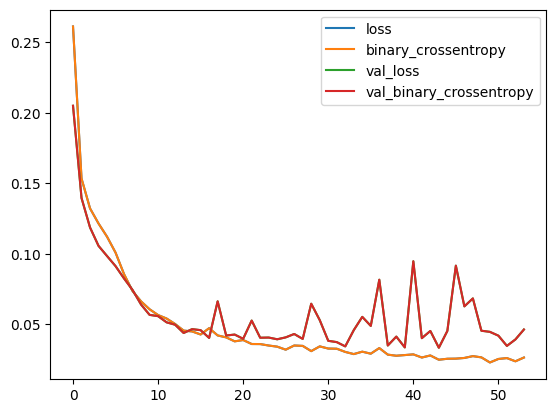

In [148]:
pd.DataFrame(model.history.history).plot()

In [149]:
train_pred = model.predict(X_train_transformed)

360/360 [==============================] - 1s 2ms/step


In [150]:
train_binary_predictions = (train_pred >= 0.5).astype(int)

In [151]:
confusion_matrix(y_train,train_binary_predictions)

array([[5697,   52],
       [  12, 5737]])

In [152]:
print(classification_report(y_train,train_binary_predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5749
           1       0.99      1.00      0.99      5749

    accuracy                           0.99     11498
   macro avg       0.99      0.99      0.99     11498
weighted avg       0.99      0.99      0.99     11498



In [153]:
precision_score(y_train,train_binary_predictions)

0.9910174468820176

In [154]:
recall_score(y_train,train_binary_predictions)

0.997912680466168

In [155]:
X_test_transformed = pipe.fit_transform(X_test,y_test)

In [156]:
test_pred = model.predict(X_test_transformed)

47/47 [==============================] - 0s 6ms/step


In [157]:
test_binary_predictions = (test_pred >= 0.5).astype(int)

In [159]:
confusion_matrix(y_test,test_binary_predictions)

array([[733,   6],
       [ 21, 719]])

In [160]:
precision_score(y_train,train_binary_predictions)

0.9910174468820176

In [161]:
recall_score(y_train,train_binary_predictions)

0.997912680466168

In [165]:
model.save('/content/fraud_model.keras')

In [166]:
import keras

In [167]:
loaded_model = keras.models.load_model('/content/fraud_model.keras')

In [169]:
loaded_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 32)                192       
                                                                 
 batch_normalization_10 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 dense_58 (Dense)            (None, 32)                1056      
                                                                 
 batch_normalization_11 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 dense_59 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1537 (6.00 KB)
Trainable params: 1409 (